# Welcome to ML4D BroadE!

### Agenda
10:00-10:05: Intro Videos, Demos and Downloads 

10:05-10:30: Run docker jupyter server and open broad.ipynb and run first cell

10:30-10:45: Fundamental ML (linear and logistic regression, SGD, depth and interpretation)

10:45-11:00: Train models on well-studied datasets (MNIST, CIFAR10)

11:00-11:30: ML4CVD Abstractions: Tensorization, TensorMaps and the ModelFactory

11:30-11:45: Coffee Break, Discussion and Data Exploration (groups coalesce: feature not bug)

11:45-11:55: Neurologist pep Talk from Chris Anderson

11:55-12:30: Defining TensorMaps on Qure.ai sets.

12:15-12:30: Training models on the datasets

12:30-12:45: Saliency Maps

12:45-12:59: Discussion and TensorMaps on your data, Tensorboard, Hyperparameter optimization


## Prerequisites
- Basic comfort with python, some linear algebra, some data science
- Download & Install Docker: https://docs.docker.com/install/
- Download ML4D_BroadE.zip from Google Drive: 
- Unzip ml-broade.zip
- Open a Command line terminal and `cd` to the ml-broade directory
- Build your docker! run `docker build -t ml4cvd-mkl .` (This will take a little while)
- One docker is built run the jupyter server: `docker run -it -p 8888:8888 -u $(id -u):$(id -g) --cpus=4 --memory=8g -v $PWD:/tf -it ml4cvd-mkl:latest`
- Download ml-broade-data folder (big or small depending on how much free space you have).
- Once data is downloaded, kill the jupyter server hold `ctrl-c` in the terminal and restart with: `docker run -it -v $HOME/ml-broade-data/:/data -p 6006:6006 -p 8888:8888 -u $(id -u):$(id -g) --cpus=4 --memory=8g -v $PWD:/tf -it ml4cvd-mkl:latest` (edit the path `$HOME/ml-broade-data/` to point at your data folder download location.)
- Click the trust button on your Jupyter notebook
- Now we are ready to teach the machines!

In [6]:
# Imports
import os
import sys
import pickle
import random
from typing import List, Dict, Callable
from collections import defaultdict, Counter

import csv
import gzip
import h5py
import shutil
import zipfile
import pydicom
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import gridspec

from keras import metrics
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten

from ml4cvd.defines import StorageType
from ml4cvd.arguments import parse_args, TMAPS, _get_tmap
from ml4cvd.TensorMap import TensorMap, Interpretation
from ml4cvd.tensor_generators import test_train_valid_tensor_generators
from ml4cvd.models import train_model_from_generators, make_multimodal_multitask_model, _inspect_model
from ml4cvd.recipes import test_multimodal_multitask, train_multimodal_multitask, saliency_maps

Using TensorFlow backend.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [7]:
# Constants
ZIP_FOLDER = '/data/zips/' 
HD5_FOLDER = '/data/hd5s/'
MODEL_FOLDER = './models/'
EXCLUDE_SERIES = ['4cc', '_&_', '5mm', '3mm', 'helical']

# Python features we make lots of use of in this notebook:
- F Strings
- Callback Functions

### Linear Regression
We explore machine learning on Bio medical data using Cloud computing, Python, Tensorflow, and the ML4CVD codebase.

We will start with linear regression.  Our model is a vector, one weight for each input feature, and a single bias weight.

\begin{equation}
y = xw + b
\end{equation}

For notational convenience absorb the bias term into the weight vector by adding a 1 to the input data matrix $X$

\begin{equation}
y = [\textbf{1}, X][b, \textbf{w}]^T
\end{equation}

#### The Dense Layer is Matrix (Tensor) Multiplication
![Matrix Multiplication](https://www.mathwarehouse.com/algebra/matrix/images/matrix-multiplication/how-to-multiply-2-matrices-demo.gif)

In [16]:
def linear_regression():
    samples = 40
    real_weight = 2.0
    real_bias = 0.5
    x = np.linspace(-1, 1, samples)
    y = real_weight*x + real_bias + (np.random.randn(*x.shape) * 0.1)

    linear_model = Sequential()
    linear_model.add(Dense(1, input_dim=1))
    linear_model.compile(loss='mean_squared_error', optimizer='sgd')
    linear_model.summary()
    linear_model.fit(x, y, batch_size=1, epochs=6)

    learned_slope = linear_model.get_weights()[0][0][0]
    learned_bias = linear_model.get_weights()[1][0]
    print('Learned slope:',  learned_slope, 'real slope:', real_weight, 'learned bias:', learned_bias, 'real bias:', real_bias)

    plt.plot(x, y)
    plt.plot([-1,1], [-learned_slope+learned_bias, learned_slope+learned_bias], 'r')
    plt.show()
    print('Linear Regression complete!')

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 1)                 2         
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________
Epoch 1/6
40/40 [==============================] - 0s 4ms/step - loss: 0.4502
Epoch 2/6
40/40 [==============================] - 0s 1ms/step - loss: 0.2097
Epoch 3/6
40/40 [==============================] - 0s 1ms/step - loss: 0.1129
Epoch 4/6
40/40 [==============================] - 0s 843us/step - loss: 0.0657
Epoch 5/6
40/40 [==============================] - 0s 863us/step - loss: 0.0403
Epoch 6/6
40/40 [==============================] - 0s 906us/step - loss: 0.0263
Learned slope: 1.847501 real slope: 2.0 learned bias: 0.4944966 real bias: 0.5


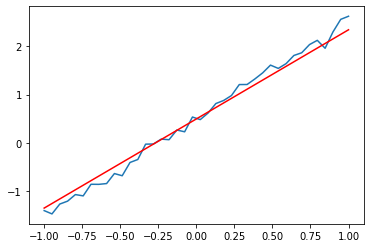

Linear Regression complete!


In [17]:
linear_regression()

## Now Logistic Regression:
We take the real-valued predictions from linear regression and squish them with a sigmoid.

\begin{equation}
\textbf{y} = \sigma(X\textbf{w} + b)
\end{equation}

where 
\begin{equation}
\sigma(x) = \frac{e^x}{1+e^x} = \frac{1}{1+e^{-x}}
\end{equation}

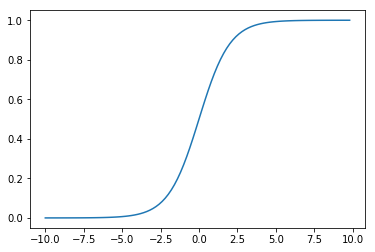

In [5]:
def sigmoid(x):
    a = []
    for item in x:
        a.append(np.exp(item)/(1+np.exp(item)))
    return a

x = np.arange(-10., 10., 0.2)
sig = sigmoid(x)
plt.plot(x,sig)
plt.show()

In [6]:
def logistic_regression(epochs = 600, num_labels = 10):
    train, test, valid = load_data('mnist.pkl.gz')  
    
    train_y = make_one_hot(train[1], num_labels)
    valid_y = make_one_hot(valid[1], num_labels)
    test_y = make_one_hot(test[1], num_labels)

    logistic_model = Sequential()
    logistic_model.add(Dense(num_labels, activation='softmax', input_dim=784, name='mnist_templates'))
    logistic_model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
    logistic_model.summary()
    
    templates = logistic_model.layers[0].get_weights()[0]
    plot_templates(templates, 0)
    print('weights shape:', templates.shape)

    for e in range(epochs):
        trainidx = random.sample(range(0, train[0].shape[0]), 8192)
        x_batch = train[0][trainidx,:]
        y_batch = train_y[trainidx]
        logistic_model.train_on_batch(x_batch, y_batch)
        if e % 100 == 0:
            plot_templates(logistic_model.layers[0].get_weights()[0], e)
            print('Logistic Model test set loss and accuracy:', logistic_model.evaluate(test[0], test_y), 'at epoch', e)


def plot_templates(templates, epoch):
    n = 10
    templates = templates.reshape((28,28,n))
    plt.figure(figsize=(16, 8))
    for i in range(n):
        ax = plt.subplot(2, 5, i+1)		
        plt.imshow(templates[:, :, i])
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plot_name = "./regression_example/mnist_templates_"+str(epoch)+".png"
    if not os.path.exists(os.path.dirname(plot_name)):
        os.makedirs(os.path.dirname(plot_name))		
    plt.savefig(plot_name)


def make_one_hot(y, num_labels):
    ohy = np.zeros((len(y), num_labels))
    for i in range(0, len(y)):
        ohy[i][y[i]] = 1.0
    return ohy


def load_data(dataset):
    ''' Loads the dataset
    :param dataset: the path to the dataset (here MNIST)'''
    data_dir, data_file = os.path.split(dataset)
    if data_dir == "" and not os.path.isfile(dataset):
        # Check if dataset is in the data directory.
        new_path = os.path.join("data", dataset)
        if os.path.isfile(new_path) or data_file == 'mnist.pkl.gz':
            dataset = new_path

    if (not os.path.isfile(dataset)) and data_file == 'mnist.pkl.gz':
        from urllib.request import urlretrieve
        origin = ('http://www.iro.umontreal.ca/~lisa/deep/data/mnist/mnist.pkl.gz')
        print('Downloading data from %s' % origin)
        if not os.path.exists(os.path.dirname(dataset)):
            os.makedirs(os.path.dirname(dataset))	
        urlretrieve(origin, dataset)

    print('loading data...')
    f = gzip.open(dataset, 'rb')
    if sys.version_info[0] == 3:
        u = pickle._Unpickler(f)
        u.encoding = 'latin1'
        train_set, valid_set, test_set = u.load()
    else:
        train_set, valid_set, test_set = pickle.load(f)
    f.close()

    return train_set, valid_set, test_set

def plot_mnist(sides):
    train, _, _ = load_data('mnist.pkl.gz')
    print(train[0].shape)
    mnist_images = train[0].reshape((-1, 28, 28, 1))
    sides = int(np.ceil(np.sqrt(min(sides, mnist_images.shape[0]))))
    _, axes = plt.subplots(sides, sides, figsize=(16, 16))
    for i in range(sides*sides):
        axes[i // sides, i % sides].imshow(mnist_images[i, ..., 0], cmap='gray')

# Look B4 U Learn!

loading data...
(50000, 784)


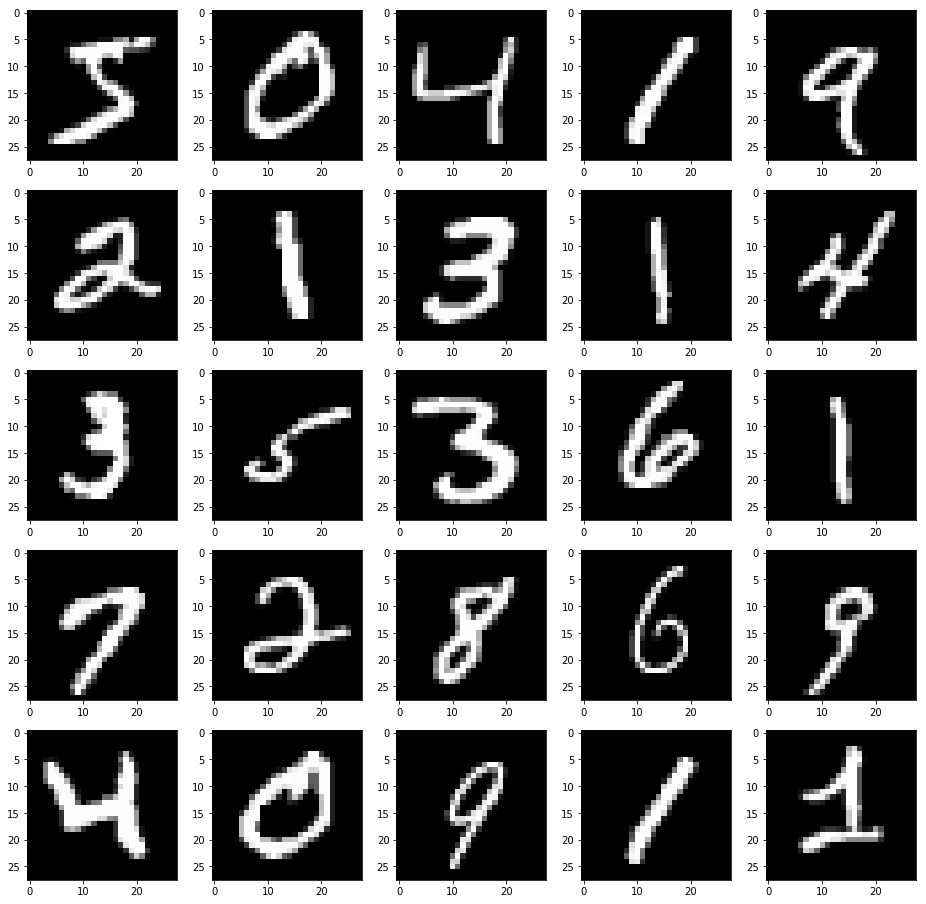

In [7]:
plot_mnist(25)

## Cross Entropy Loss:
Our favorite loss function for categorical data.
\begin{equation}
L(true, model) = -\sum_{x\in\mathcal{X}} true(x)\, \log model(x)
\end{equation}

Binary cross entropy with $N$ data points $x$ each with a binary label: 
\begin{equation}
true(x) \in \{0, 1\} \\
L(true, model) = -\frac{1}{N}\sum^N_{i=1} true(x_i)\log(model(x_i)) + (1-true(x_i))log(1-model(x_i))
\end{equation}

This is the Kullback Leibler divergence between the true distribution and the predicted. 
This function emerges in many fields as diverse as probability, information theory, and physics.
What is the information difference between the truth and our model?  How much data do I lose by replacing the truth with the model's predictions. What is the temperature difference between my predictions and the truth?!

Categorical cross entropy with $K$ different classes or labels: 
\begin{equation}
true(x) \in \{0, 1, 2, ..., K\} \\
L(true, model) = -\frac{1}{N}\sum^N_{i=1}\sum^K_{j=1} y_{ik}\log(q_k(x_i)))
\end{equation}

loading data...
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mnist_templates (Dense)      (None, 10)                7850      
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________
weights shape: (784, 10)
10000/10000 [==============================] - 0s 33us/step
Logistic Model test set loss and accuracy: [2.360117454147339, 0.119] at epoch 0
10000/10000 [==============================] - 0s 30us/step
Logistic Model test set loss and accuracy: [1.550956068611145, 0.6712] at epoch 100
10000/10000 [==============================] - 0s 31us/step
Logistic Model test set loss and accuracy: [1.1858116136550902, 0.7772] at epoch 200
10000/10000 [==============================] - 0s 31us/step
Logistic Model test set loss and accuracy: [0.9847884492874146, 0.8134] at epoch 300
10000/10000 [=================

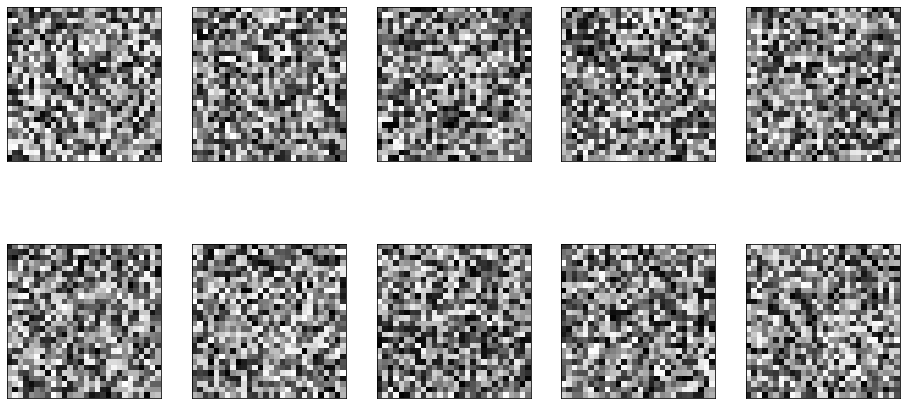

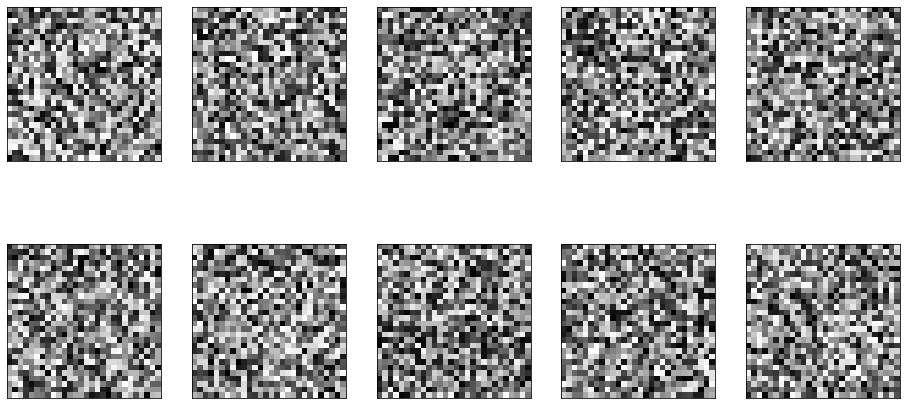

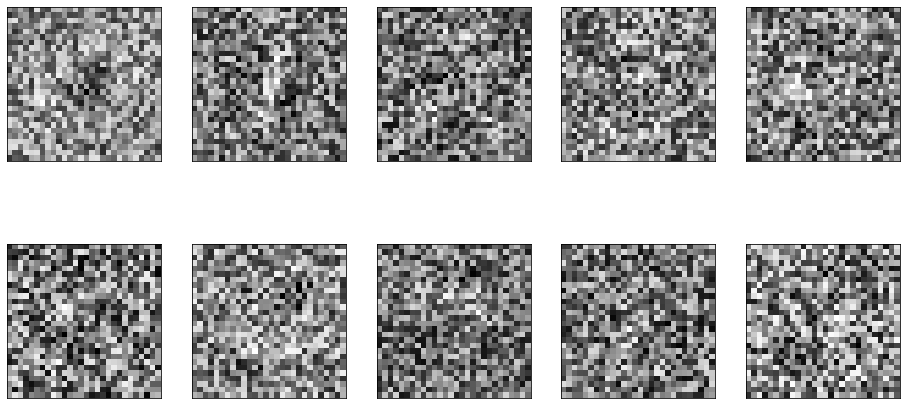

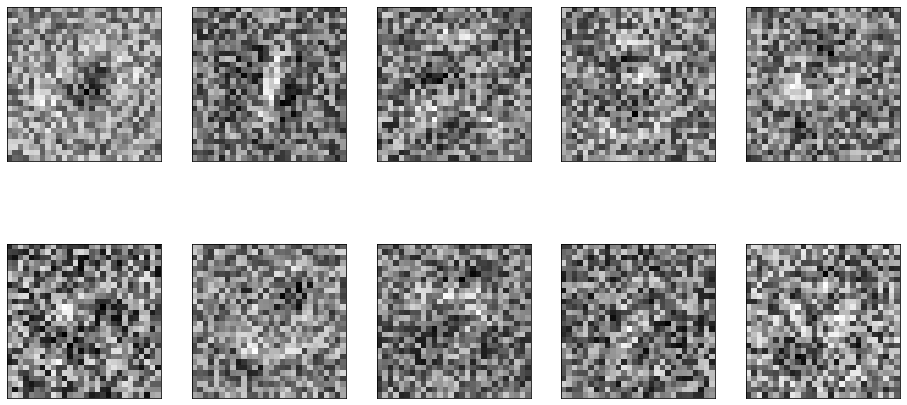

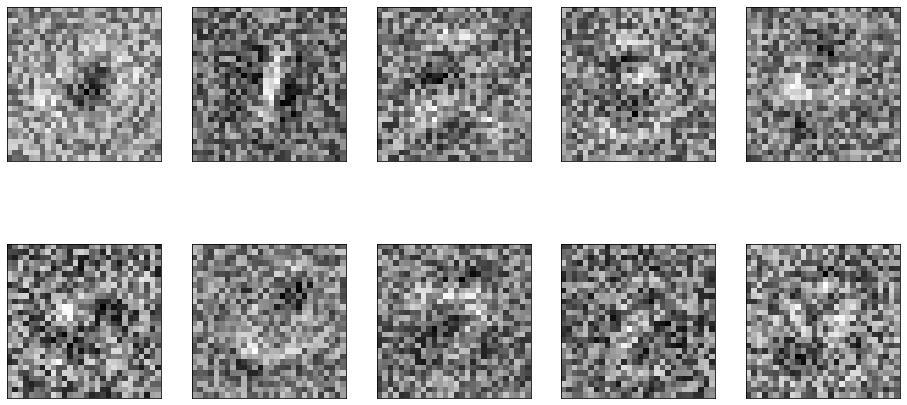

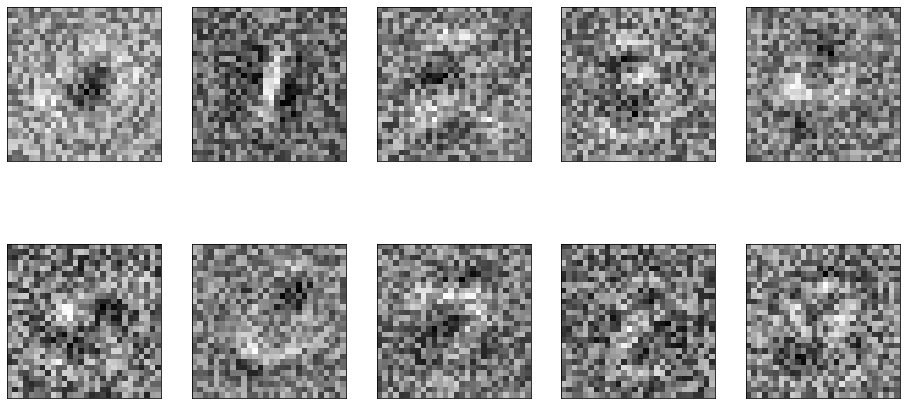

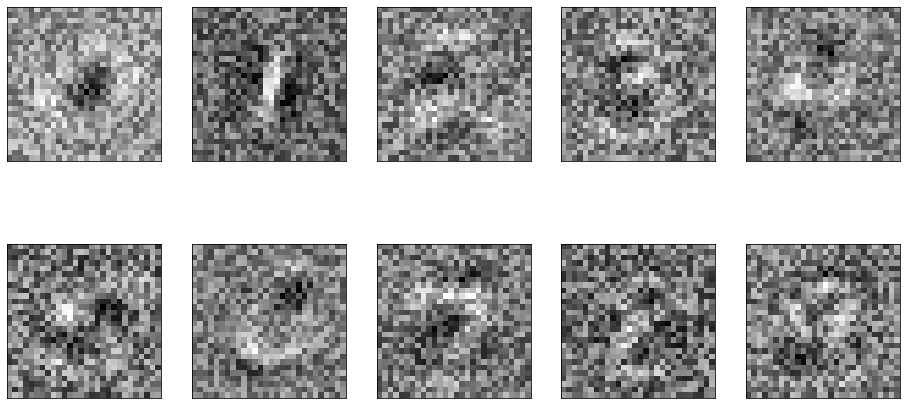

In [8]:
logistic_regression()

# Deep Models: "Hidden" Layers and The MultiLayerPerceptron

In [9]:
def multilayer_perceptron():
    train, test, valid = load_data('mnist.pkl.gz')

    num_labels = 10
    train_y = make_one_hot(train[1], num_labels)
    valid_y = make_one_hot(valid[1], num_labels)
    test_y = make_one_hot(test[1], num_labels)

    mlp_model = Sequential()
    mlp_model.add(Dense(500, activation='relu', input_dim=784))
    mlp_model.add(Dense(num_labels, activation='softmax'))
    mlp_model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
    mlp_model.summary()
    mlp_model.fit(train[0], train_y, validation_data=(valid[0],valid_y), batch_size=32, epochs=3)
    print('Multilayer Perceptron trained. Test set loss and accuracy:', mlp_model.evaluate(test[0], test_y))

multilayer_perceptron()

loading data...
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 500)               392500    
_________________________________________________________________
dense_3 (Dense)              (None, 10)                5010      
Total params: 397,510
Trainable params: 397,510
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/3
50000/50000 [==============================] - 4s 82us/step - loss: 0.6697 - acc: 0.8387 - val_loss: 0.3614 - val_acc: 0.9061
Epoch 2/3
50000/50000 [==============================] - 4s 79us/step - loss: 0.3421 - acc: 0.9056 - val_loss: 0.2918 - val_acc: 0.9182
Epoch 3/3
10000/10000 [==============================] - 0s 31us/step
Multilayer Perceptron trained. Test set loss and accuracy: [0.2501177648484707, 0.931]


# Convolutions Flip, Slide, Multiply, Add
Convolutions look for their kernel in a larger signal.

In convolution, you always and only find what you're looking with.

Convolution and cross correlation are deeply related:

\begin{equation}
f(t) \circledast g(t) \triangleq\ \int_{-\infty}^\infty f(\tau) g(t - \tau) \, d\tau. = \int_{-\infty}^\infty f(t-\tau) g(\tau)\, d\tau.
\end{equation}



![title](https://upload.wikimedia.org/wikipedia/commons/2/21/Comparison_convolution_correlation.svg)

In [10]:
def convolutional_neural_network(filters=32, kernel_size=(3,3), padding='valid', num_labels = 10):
    train, test, valid = load_data('mnist.pkl.gz')

    train_y = make_one_hot(train[1], num_labels)
    valid_y = make_one_hot(valid[1], num_labels)
    test_y = make_one_hot(test[1], num_labels)
    
    print(train[0].shape)
    mnist_images = train[0].reshape((-1, 28, 28, 1))
    mnist_valid = valid[0].reshape((-1, 28, 28, 1))
    mnist_test = test[0].reshape((-1, 28, 28, 1))

    cnn_model = Sequential()
    cnn_model.add(Conv2D(input_shape=(28, 28, 1), filters=filters, kernel_size=kernel_size, padding=padding, activation='relu'))
    cnn_model.add(Conv2D(filters=filters, kernel_size=kernel_size, padding=padding, activation='relu'))
    cnn_model.add(Conv2D(filters=filters, kernel_size=kernel_size, padding=padding, activation='relu'))
    cnn_model.add(Flatten())
    cnn_model.add(Dense(16, activation='relu'))
    cnn_model.add(Dense(num_labels, activation='softmax'))
    cnn_model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
    cnn_model.summary()
    cnn_model.fit(mnist_images, train_y, validation_data=(mnist_valid, valid_y), batch_size=32, epochs=3)
    
    print('Convolutional Neural Network trained. Test set loss and accuracy:', cnn_model.evaluate(mnist_test, test_y))

convolutional_neural_network()

loading data...
(50000, 784)
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 22, 22, 32)        9248      
_________________________________________________________________
flatten_1 (Flatten)          (None, 15488)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 16)                247824    
_________________________________________________________________
dense_5 (Dense)              (None, 10)                170       
Total params: 266,810
Trainable params: 266,810
Non-trainable params: 0
___________________

# Why (and When!) is Convolution Helpful?
- Decouples input size from model size
- Translationally Equivariant (Not Invariant), so we can find features wherever they might occur in the signal
- Local structure is often informative
- But not always! (eg Tabular data)

# ML4CVD Cosmology:  Tensors all the way down.


# ML4CVD Abstractions: Tensorization, the TensorMap, and the ModelFactory

## Tensorization
Tensorization is the process of gathering any number of input files and consolidating them into compressed HD5 files.  We tend to make one HD5 file per sample in the study.  The files contain the raw data and labels we will use to train models.  It tends to be efficient to separate tensor construction from model training.

In [4]:
def parse_dicoms(dicom_folder, stats):
    dcm_file = ''
    my_stats = Counter()
    series = defaultdict(list)
    for root, _, files in os.walk(dicom_folder):
        for name in files:
            dcm_file = os.path.join(root, name)
            if not dcm_file.endswith('.dcm'):
                continue
            try:
                dcm = pydicom.read_file(dcm_file)
                my_stats[f'Shape {dcm.pixel_array.shape}'] += 1
                my_stats['count'] += 1
                my_stats[f'Series Number {dcm.SeriesNumber}'] += 1
                my_stats[f'Series Description {dcm.SeriesDescription}'] += 1
                my_stats[f'Pixel spacing{dcm.PixelSpacing}'] += 1
                series[dcm.SeriesDescription.lower().trim().replace(' ', '_').replace('/', '_')].append(dcm)
            except:
                my_stats['got an error'] += 1
                break
    print(f'\n At DICOM {dcm_file}')
    for k in my_stats:
        print(f'{k} has {my_stats[k]}') 
    
    try:
        tensors = {}
        for k in series:
            tensors[k] = np.zeros((512, 512, len(series[k])))
            for dcm in series[k]:
                tensors[k][..., dcm.InstanceNumber-1] = dcm.pixel_array
    except:
        my_stats['got a tensorization error'] += 1
            
    stats.update(my_stats)
    return tensors

In [ ]:
def tensorize_qure_ai_dicoms(zip_folder, dicom_folder, hd5_folder, delete_dicoms=True, limit_dicoms=-1):
    raw_data = {}
    stats = Counter()
    if not os.path.exists(dicom_folder):
        os.makedirs(dicom_folder)
    if not os.path.exists(hd5_folder):
        os.makedirs(hd5_folder)    
    for z in os.listdir(zip_folder):
        if os.path.exists(os.path.join(hd5_folder, z.replace('.zip', '.hd5'))):
            continue
        with zipfile.ZipFile(zip_folder + z, "r") as zip_ref:
            zip_ref.extractall(dicom_folder)
            tensors = parse_dicoms(dicom_folder, stats)
            with h5py.File(os.path.join(hd5_folder, z.replace('.zip', '.hd5')), 'w') as hd5:
                for t in tensors:
                    hd5.create_dataset(t, data=tensors[t], compression='gzip')
        if delete_dicoms:
            shutil.rmtree(dicom_folder)
        if limit_dicoms > 0 and stats['count'] > limit_dicoms:
            break

    print('\n\n Full stats below:')
    for k in stats:
        print(f'{k} has {stats[k]}')

tensorize_qure_ai_dicoms(ZIP_FOLDER, './dicoms/', './test/', limit_dicoms=1000)


 At DICOM ./dicoms/CQ500CT229 CQ500CT229/Unknown Study/CT PRE CONTRAST BONE/CT000006.dcm
got an error has 3

 At DICOM ./dicoms/CQ500CT228 CQ500CT228/Unknown Study/CT Plain/CT000006.dcm
Shape (512, 512) has 4
count has 4
Series Number 3 has 1
Series Description 4cc sec 150cc D3D on has 3
Pixel spacing['0.390625', '0.390625'] has 3
got an error has 4
Series Number 4 has 1
Series Number 5 has 1
Series Number 2 has 1
Series Description Plain has 1
Pixel spacing['0.488281', '0.488281'] has 1

 At DICOM ./dicoms/CQ500CT22 CQ500CT22/Unknown Study/CT Plain/CT000006.dcm
Shape (512, 512) has 2
count has 2
Series Number 3 has 1
Series Description PLAIN THIN has 1
Pixel spacing['0.445312', '0.445312'] has 2
got an error has 2
Series Number 2 has 1
Series Description Plain has 1

 At DICOM ./dicoms/CQ500CT223 CQ500CT223/Unknown Study/CT Plain/CT000006.dcm
got an error has 2

 At DICOM ./dicoms/CQ500CT222 CQ500CT222/Unknown Study/CT PRE CONTRAST BONE/CT000006.dcm
Shape (512, 512) has 3
count has 3

In [18]:
!head -5 ./reads.csv 

In [19]:
def tensorize_qure_ai_reads(read_file, hd5_folder):
    stats = Counter()
    with open(read_file, 'r') as my_csv:
        lol = list(csv.reader(my_csv, delimiter=','))
        header = [h.replace(':', '_').lower() for h in lol[0]]
        print(f'header is {header}')
        for row in lol[1:]:
            try:
                with h5py.File(f'{hd5_folder}{row[0]}.hd5', 'a') as hd5:
                    for i, value in enumerate(row[2:]):
                        hd5.create_dataset(header[i+2], data=[int(value)])
            except:
                print(f'Could not open {row[0]}')
    for k in stats:
        print(f'{k} has {stats[k]}')

### Look at the DICOM series we have

## TensorMaps
The critical data structure in the ML4CVD codebase is the TensorMap.
This abstraction provides a way to translate ***any*** kind of input data, into structured numeric tensors with clear semantics for interpretation and modeling.  TensorMaps guarantee a shape, a way to consturct tensors of that shape from the HD5 files created during tensorization and a meaning to the values in the tensor that the TensorMap yields.

In [20]:
mnist_image = TensorMap('mnist_image', Interpretation.CONTINUOUS, shape=(28, 28))
mnist_image = TensorMap('mnist_image', Interpretation.CONTINUOUS, shape=(28, 28, 1))

mnist_channel_map = {'zero': 0, 'one': 1, 'two': 2, 'three': 3, 'zero': 4, 'zero': 5, 
                     'six': 6, 'seven': 9, 'eight': 8, 'nine': 9}

mnist_class = TensorMap('mnist_class', Interpretation.CATEGORICAL, shape=(10,), channel_map=mnist_channel_map)

In [21]:
cifar_image = TensorMap('cifar_image', Interpretation.CONTINUOUS, shape=(32, 32, 3))

cifar_channel_map = {'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4, 'dog': 5, 
                     'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}

cifar_class = TensorMap('cifar_class', Interpretation.CATEGORICAL, shape=(10,), channel_map=cifar_channel_map)

In [21]:
def tmaps_by_sample_id(tensor_folder: str, sample_id: str, tmaps: List[TensorMap]):
    path = os.path.join(tensor_folder, sample_id + '.hd5')
    result_dict = defaultdict(lambda: None)
    if os.path.isfile(path):
        with h5py.File(path, 'r') as hd5:
            for tmap in tmaps:
                try:
                    result_dict[tmap] = tmap.normalize_and_validate(tmap.tensor_from_file(tmap, hd5))
                except (IndexError, KeyError, ValueError, OSError, RuntimeError):
                    continue
    return result_dict

In [22]:
def plot_array_3d(a):
    slice_axis = -1
    sides = int(np.ceil(np.sqrt(a.shape[slice_axis])))
    _, axes = plt.subplots(sides, sides, figsize=(16, 16))
    print(a.shape)
    vmin = np.min(a)
    vmax = np.max(a)
    for i in range(a.shape[slice_axis]):
        axes[i//sides, i%sides].imshow(a[..., i], cmap='gray', vmin=vmin, vmax=vmax)
        axes[i//sides, i%sides].set_yticklabels([])
        axes[i//sides, i%sides].set_xticklabels([])

In [34]:
def slice_map(exclude=EXCLUDE_SERIES):
    def slice_from_hd5(tm, hd5, dependents={}):
        for k in np.random.permutation(list(hd5.keys())):
            if any(x in k for x in exclude):
                continue
            if isinstance(hd5[k], h5py.Dataset) and len(hd5[k].shape) == 3 and hd5[k].shape[-1] > 50:
                random_index = np.random.randint(hd5[k].shape[-1]-tm.shape[-1])
                random_slices = np.array(hd5[k][..., random_index:random_index+tm.shape[-1]], dtype=np.float32)
                return random_slices
        raise ValueError('No CT slices in HD5')
    return slice_from_hd5
   
TMAPS['slice_map'] = TensorMap('slice_map', shape=(512, 512, 1), tensor_from_file=slice_map(), 
                               cacheable=False, normalization={'zero_mean_std1': True})
TMAPS['slice_map5'] = TensorMap('slice_map5', shape=(512, 512, 5), tensor_from_file=slice_map(), 
                                cacheable=False, normalization={'zero_mean_std1': True})
TMAPS['slice_map25'] = TensorMap('slice_map25', shape=(512, 512, 25), tensor_from_file=slice_map(), 
                                 cacheable=False, normalization={'zero_mean_std1': True})

slice_map25 has (512, 512, 25)
(512, 512, 25)


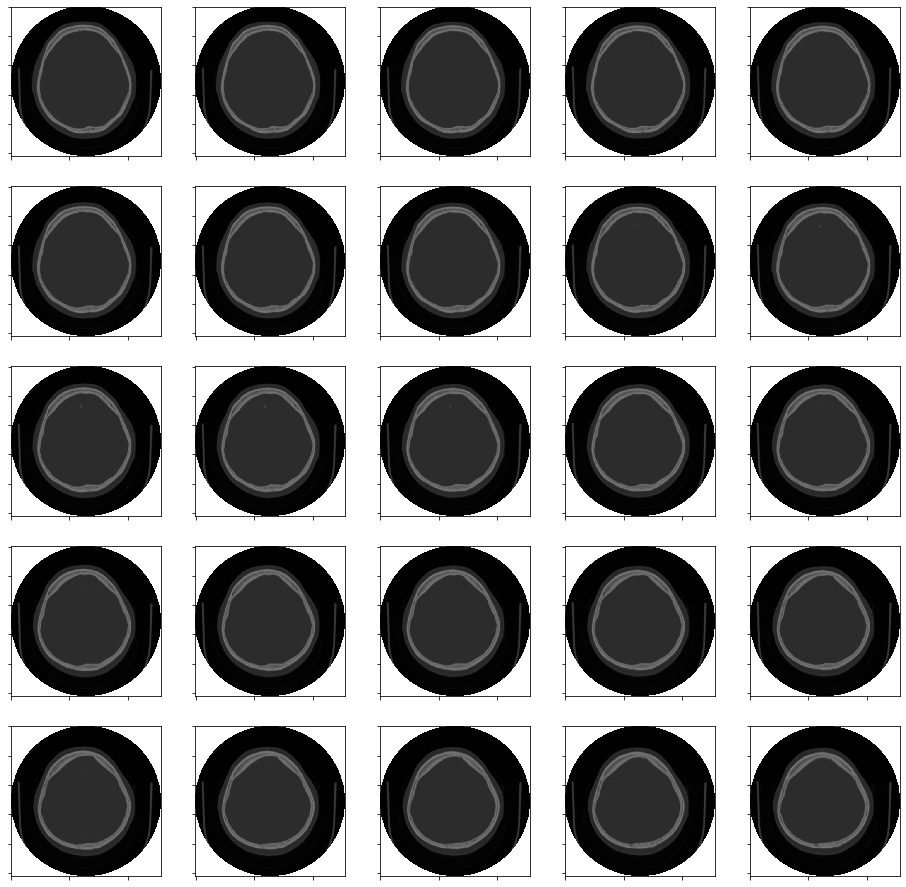

In [36]:
t = tmaps_by_sample_id(HD5_FOLDER, 'CQ500-CT-222', [ _get_tmap('slice_map25')])
for k in t:
    print(k.name, 'has', t[k].shape)
    plot_array_3d(t[k])

In [37]:
def crop_voxels(exclude=EXCLUDE_SERIES):
    def crop_voxels_from_hd5(tm, hd5, dependents={}):
        for k in np.random.permutation(list(hd5.keys())):
            if isinstance(hd5[k], h5py.Dataset) and len(hd5[k].shape) == 3:
                if any(x in k for x in exclude):
                    continue
                if hd5[k].shape[-1] < 50:
                    continue
                x_index = np.random.randint(hd5[k].shape[0]-tm.shape[0])
                y_index = np.random.randint(hd5[k].shape[1]-tm.shape[1])
                middle_index = hd5[k].shape[-1] // 2
                start_index = middle_index - (tm.shape[-1] // 2)
                stop_index = middle_index + (tm.shape[-1] // 2) + tm.shape[-1]%2
                z_index = np.random.randint(hd5[k].shape[2]-tm.shape[2])
                random_slices = np.array(hd5[k][x_index:x_index+tm.shape[0], y_index:y_index+tm.shape[1], start_index:stop_index], dtype=np.float32)
                return random_slices
        raise ValueError('No CT slices in HD5')
    return crop_voxels_from_hd5

TMAPS['crop_thin_16'] = TensorMap('crop_thin_16', shape=(16, 16, 16), tensor_from_file=crop_voxels(), 
                                  cacheable=False, normalization={'zero_mean_std1': True})
    
TMAPS['crop_thin_64'] = TensorMap('crop_thin_64', shape=(64, 64, 64), tensor_from_file=crop_voxels(), 
                                  cacheable=False, normalization={'zero_mean_std1': True})

TMAPS['crop_thin_316'] = TensorMap('crop_thin_316', shape=(316, 192, 64), tensor_from_file=crop_voxels(), 
                                   cacheable=False, normalization={'zero_mean_std1': True})

TMAPS['crop_thin_372'] = TensorMap('crop_thin_372', shape=(372, 292, 121), tensor_from_file=crop_voxels(), 
                                   cacheable=False, normalization={'zero_mean_std1': True})

TMAPS['crop_thin_256'] = TensorMap('crop_thin_256', shape=(256, 256, 128), tensor_from_file=crop_voxels(), 
                                   cacheable=False, normalization={'zero_mean_std1': True})

TMAPS['crop_thin_396'] = TensorMap('crop_thin_396', shape=(396, 396, 144), tensor_from_file=crop_voxels(), 
                                   cacheable=False, normalization={'zero_mean_std1': True})


crop_thin_316 has (316, 192, 64)
(316, 192, 64)


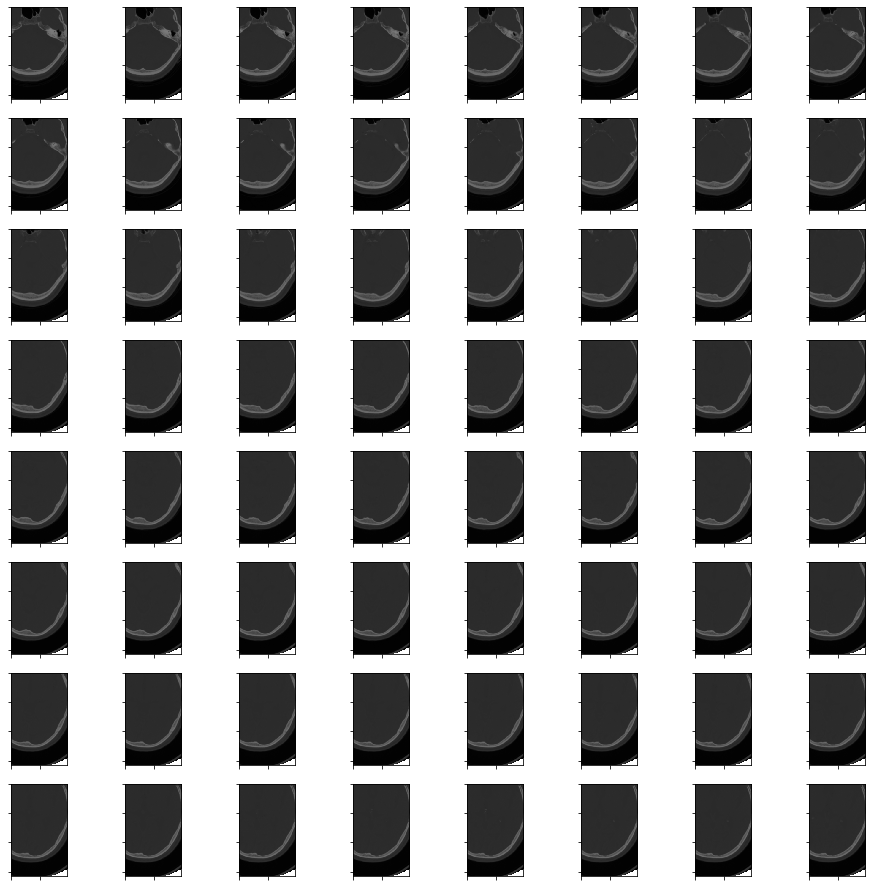

In [38]:
t = tmaps_by_sample_id(HD5_FOLDER, 'CQ500-CT-212', [ _get_tmap('crop_thin_316')])
for k in t:
    print(k.name, 'has', t[k].shape)
    plot_array_3d(t[k])

In [64]:
def thin_slice(exclude=EXCLUDE_SERIES):
    def thin_slice_from_hd5(tm, hd5, dependents={}):
        for k in np.random.permutation(list(hd5.keys())):
            if any(x in k for x in exclude):
                continue
            if hd5[k].shape[-1] < 50:
                continue
            if isinstance(hd5[k], h5py.Dataset) and len(hd5[k].shape) == 3:
                random_index = np.random.randint(hd5[k].shape[-1]-tm.shape[-1])
                random_slices = np.array(hd5[k][..., random_index:random_index+tm.shape[-1]], dtype=np.float32)
                random_slices = np.clip(random_slices, 3000, 10000)
                return random_slices
        raise ValueError('No CT slices in HD5')
    return thin_slice_from_hd5
    
TMAPS['thin_slice_map16'] = TensorMap('thin_slice_map16', shape=(512, 512, 16), tensor_from_file=thin_slice([]), 
                                      cacheable=False, normalization={'zero_mean_std1': True})
TMAPS['thin_slice_map50'] = TensorMap('thin_slice_map50', shape=(512, 512, 50), tensor_from_file=thin_slice([]), 
                                      cacheable=False, normalization={'zero_mean_std1': True})
TMAPS['thin_slice_map200'] = TensorMap('thin_slice_map200', shape=(512, 512, 200), tensor_from_file=thin_slice(), 
                                       cacheable=False, normalization={'zero_mean_std1': True})

thin_slice_map50 has (512, 512, 50)
(512, 512, 50)


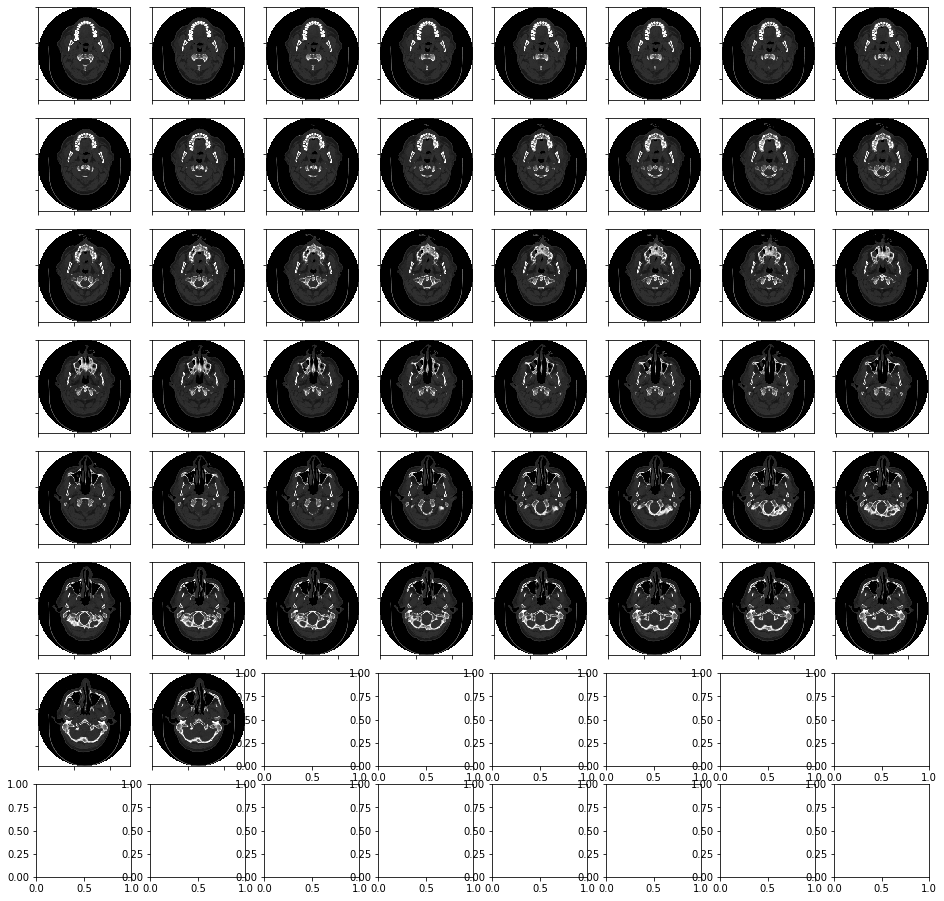

In [66]:
t = tmaps_by_sample_id(HD5_FOLDER, 'CQ500-CT-212', [ _get_tmap('thin_slice_map50')])
for k in t:
    print(k.name, 'has', t[k].shape)
    plot_array_3d(t[k])   

## Start with something simple and obvious for a human

In [69]:
def slice_count(exclude=EXCLUDE_SERIES):
    def slice_count_hd5(tm, hd5, dependents={}):
        for k in np.random.permutation(list(hd5.keys())):
            if any(x in k for x in exclude):
                continue
            if isinstance(hd5[k], h5py.Dataset) and len(hd5[k].shape) == 3 and hd5[k].shape[-1] > 50:
                random_index = np.random.randint(hd5[k].shape[-1]-tm.shape[-1])
                random_slices = np.array(hd5[k][..., random_index:random_index+tm.shape[-1]], dtype=np.float32)
                dependents[tm.dependent_map] = np.sum(random_slices > 800) / np.prod(random_slices.shape)
                return random_slices
        raise ValueError('No CT slices in HD5')
    return slice_count_hd5

TMAPS['slice_map_count'] = TensorMap('slice_map_count', shape=(1,), channel_map={'count': 0}, cacheable=False)
TMAPS['slice_map_to_count'] = TensorMap('slice_map', shape=(512, 512, 2), dependent_map=TMAPS['slice_map_count'],
                                        tensor_from_file=slice_count(), cacheable=False, 
                                        normalization={'zero_mean_std1': True})

In [70]:
TMAPS['r1_fracture'] = TensorMap('r1_fracture', Interpretation.CATEGORICAL, 
                                 storage_type=StorageType.CATEGORICAL_INDEX, 
                                 channel_map={'no_r1_fracture': 0, 'r1_fracture': 1})
TMAPS['r2_fracture'] = TensorMap('r2_fracture', Interpretation.CATEGORICAL, 
                                 storage_type=StorageType.CATEGORICAL_INDEX, 
                                 channel_map={'no_r2_fracture': 0, 'r2_fracture': 1})
TMAPS['r3_fracture'] = TensorMap('r3_fracture', Interpretation.CATEGORICAL, 
                                 storage_type=StorageType.CATEGORICAL_INDEX, 
                                 channel_map={'no_r3_fracture': 0, 'r3_fracture': 1})
TMAPS['r1_calvarialfracture'] = TensorMap('r1_calvarialfracture', Interpretation.CATEGORICAL, 
                                          storage_type=StorageType.CATEGORICAL_INDEX, 
                                          channel_map={'no_r1_calvarialfracture': 0, 'r1_calvarialfracture': 1})
TMAPS['r2_calvarialfracture'] = TensorMap('r2_calvarialfracture', Interpretation.CATEGORICAL, 
                                          storage_type=StorageType.CATEGORICAL_INDEX, channel_map={'no_r2_calvarialfracture': 0, 'r2_calvarialfracture': 1})
TMAPS['r3_calvarialfracture'] = TensorMap('r3_calvarialfracture', Interpretation.CATEGORICAL, 
                                          storage_type=StorageType.CATEGORICAL_INDEX, channel_map={'no_r3_calvarialfracture': 0, 'r3_calvarialfracture': 1})

TMAPS['r1_masseffect'] = TensorMap('r1_masseffect', Interpretation.CATEGORICAL, 
                                   storage_type=StorageType.CATEGORICAL_INDEX, channel_map={'no_r1_masseffect': 0, 'r1_masseffect': 1})
TMAPS['r2_masseffect'] = TensorMap('r2_masseffect', Interpretation.CATEGORICAL, 
                                   storage_type=StorageType.CATEGORICAL_INDEX, channel_map={'no_r2_masseffect': 0, 'r2_masseffect': 1})
TMAPS['r3_masseffect'] = TensorMap('r3_masseffect', Interpretation.CATEGORICAL, 
                                   storage_type=StorageType.CATEGORICAL_INDEX, channel_map={'no_r3_masseffect': 0, 'r3_masseffect': 1})

TMAPS['r1_ich'] = TensorMap('r1_ich', Interpretation.CATEGORICAL, storage_type=StorageType.CATEGORICAL_INDEX, 
                            channel_map={'no_r1_ich': 0, 'r1_ich': 1})
TMAPS['r2_ich'] = TensorMap('r2_ich', Interpretation.CATEGORICAL, storage_type=StorageType.CATEGORICAL_INDEX, 
                            channel_map={'no_r2_ich': 0, 'r2_ich': 1})
TMAPS['r3_ich'] = TensorMap('r3_ich', Interpretation.CATEGORICAL, storage_type=StorageType.CATEGORICAL_INDEX, 
                            channel_map={'no_r3_ich': 0, 'r3_ich': 1})

TMAPS['r1_iph'] = TensorMap('r1_iph', Interpretation.CATEGORICAL, storage_type=StorageType.CATEGORICAL_INDEX, 
                            channel_map={'no_r1_iph': 0, 'r1_iph': 1})
TMAPS['r2_iph'] = TensorMap('r2_iph', Interpretation.CATEGORICAL, storage_type=StorageType.CATEGORICAL_INDEX, 
                            channel_map={'no_r2_iph': 0, 'r2_iph': 1})
TMAPS['r3_iph'] = TensorMap('r3_iph', Interpretation.CATEGORICAL, storage_type=StorageType.CATEGORICAL_INDEX, 
                            channel_map={'no_r3_iph': 0, 'r3_iph': 1})

TMAPS['r1_midlineshift'] = TensorMap('r1_midlineshift', Interpretation.CATEGORICAL, 
                                     storage_type=StorageType.CATEGORICAL_INDEX, 
                                     channel_map={'no_r1_midlineshift': 0, 'r1_midlineshift': 1})
TMAPS['r2_midlineshift'] = TensorMap('r2_midlineshift', Interpretation.CATEGORICAL, 
                                     storage_type=StorageType.CATEGORICAL_INDEX, 
                                     channel_map={'no_r2_midlineshift': 0, 'r2_midlineshift': 1})
TMAPS['r3_midlineshift'] = TensorMap('r3_midlineshift', Interpretation.CATEGORICAL, 
                                     storage_type=StorageType.CATEGORICAL_INDEX, 
                                     channel_map={'no_r3_midlineshift': 0, 'r3_midlineshift': 1})

TMAPS['r1_sah'] = TensorMap('r1_sah', Interpretation.CATEGORICAL, storage_type=StorageType.CATEGORICAL_INDEX, 
                            channel_map={'no_r1_sah': 0, 'r1_sah': 1})
TMAPS['r2_sah'] = TensorMap('r2_sah', Interpretation.CATEGORICAL, storage_type=StorageType.CATEGORICAL_INDEX, 
                            channel_map={'no_r2_sah': 0, 'r2_sah': 1})
TMAPS['r3_sah'] = TensorMap('r3_sah', Interpretation.CATEGORICAL, storage_type=StorageType.CATEGORICAL_INDEX, 
                            channel_map={'no_r3_sah': 0, 'r3_sah': 1})

TMAPS['r1_sdh'] = TensorMap('r1_sdh', Interpretation.CATEGORICAL, storage_type=StorageType.CATEGORICAL_INDEX, 
                            channel_map={'no_r1_sdh': 0, 'r1_sdh': 1})
TMAPS['r2_sdh'] = TensorMap('r2_sdh', Interpretation.CATEGORICAL, storage_type=StorageType.CATEGORICAL_INDEX, 
                            channel_map={'no_r2_sdh': 0, 'r2_sdh': 1})
TMAPS['r3_sdh'] = TensorMap('r3_sdh', Interpretation.CATEGORICAL, storage_type=StorageType.CATEGORICAL_INDEX, 
                            channel_map={'no_r3_sdh': 0, 'r3_sdh': 1})

TMAPS['r1_chronicbleed'] = TensorMap('r1_chronicbleed', Interpretation.CATEGORICAL, 
                                     storage_type=StorageType.CATEGORICAL_INDEX, 
                                     channel_map={'no_r1_chronicbleed': 0, 'r1_chronicbleed': 1})
TMAPS['r2_chronicbleed'] = TensorMap('r2_chronicbleed', Interpretation.CATEGORICAL, 
                                     storage_type=StorageType.CATEGORICAL_INDEX, 
                                     channel_map={'no_r2_chronicbleed': 0, 'r2_chronicbleed': 1})
TMAPS['r3_chronicbleed'] = TensorMap('r3_chronicbleed', Interpretation.CATEGORICAL, 
                                     storage_type=StorageType.CATEGORICAL_INDEX, 
                                     channel_map={'no_r3_chronicbleed': 0, 'r3_chronicbleed': 1})

# The Model Factory
The function ***make_multimodal_multitask_model()*** takes lists of TensorMaps and connects them with intelligent goo.
### Model Architectures
- Classification
- Regression
- Multitask
- Multimodal
- Multimodal Multitask
- Autoencoders

## Binary Classification of CT Slice Command Line & Architecture
Jupyter is great, but can complicate productionizing code. We try to mitigate this by interacting with the jupyter notebook as if it were a command line call to one of ML4CVD's modes. 

In [71]:
sys.argv = ['train', 
            '--tensors', HD5_FOLDER, 
            '--input_tensors', 'crop_thin_64',
            '--output_tensors', 'r1_masseffect',
            '--dense_blocks', '12', '12', '8', '8',
            '--num_workers', '0', '--cache_size', '0',
           ]
args = parse_args()

generate_train, generate_valid, generate_test = test_train_valid_tensor_generators(**args.__dict__)
model = make_multimodal_multitask_model(**args.__dict__)
_inspect_model(model, generate_train, generate_valid, 1, 1, True, './my_first_model.png')

2020-02-28 08:47:01,129 - logger:25 - INFO - Logging configuration was loaded. Log messages can be found at ./recipes_output/no_id/log_2020-02-28_08-47_0.log.
2020-02-28 08:47:01,131 - arguments:206 - INFO - Command Line was:

./scripts/tf.sh train --tensors /data/hd5s/ --input_tensors crop_thin_64 --output_tensors r1_masseffect --dense_blocks 12 12 8 8 --num_workers 0 --cache_size 0



2020-02-28 08:47:01,134 - arguments:207 - INFO - Total TensorMaps:441 Arguments are Namespace(activation='relu', aligned_dimension=16, alpha=0.5, anneal_max=1.0, anneal_rate=1.0, anneal_shift=10, app_csv=None, b_slice_force=None, balance_csvs=[], batch_size=16, bigquery_credentials_file='/mnt/ml4cvd/projects/jamesp/bigquery/bigquery-viewer-credentials.json', bigquery_dataset='broad-ml4cvd.ukbb7089_r10data', block_size=3, cache_size=0.0, categorical_field_ids=[], continuous_field_ids=[], continuous_file=None, continuous_file_column=None, continuous_file_normalize=False, conv_dilate=False, conv_dropout=0.

2020-02-28 08:47:01,649 - models:1198 - INFO - Saving architecture diagram to:./my_first_model.png
2020-02-28 08:47:04,470 - tensor_generators:110 - INFO - Starting validation_worker_0.
2020-02-28 08:47:04,474 - tensor_generators:234 - INFO - validation_worker_0 initialized cache of size 0.000 GB.
2020-02-28 08:47:04,494 - tensor_generators:110 - INFO - Starting train_worker_0.
2020-02-28 08:47:04,546 - tensor_generators:234 - INFO - train_worker_0 initialized cache of size 0.000 GB.
2020-02-28 08:47:05,357 - tensor_generators:301 - INFO - Worker validation_worker_0 - In true epoch 1:
	The following errors occurred:
		[ValueError: No CT slices in HD5] - 6
	Generator looped & shuffled over 11 paths.
	6 tensors were presented.
	The cache holds 0 out of a possible 22 tensors and is nan% full.
	So far there have been 0 cache hits.
	0 paths were skipped because they previously failed.
	0.88 seconds elapsed.


/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py:201: RuntimeWarning: invalid value encountered in double_scalars
  return np.mean(list(self.files_seen.values()) or [0]) / self.nrows


Epoch 1/1
2020-02-28 08:47:05,940 - tensor_generators:301 - INFO - Worker train_worker_0 - In true epoch 1:
	The following errors occurred:
		[ValueError: No CT slices in HD5] - 11
	Generator looped & shuffled over 19 paths.
	9 tensors were presented.
	The cache holds 0 out of a possible 38 tensors and is nan% full.
	So far there have been 0 cache hits.
	0 paths were skipped because they previously failed.
	1.39 seconds elapsed.
2020-02-28 08:47:05,982 - tensor_generators:301 - INFO - Worker validation_worker_0 - In true epoch 2:
	The following errors occurred:
		[ValueError: No CT slices in HD5] - 6
	Generator looped & shuffled over 11 paths.
	5 tensors were presented.
	The cache holds 0 out of a possible 22 tensors and is nan% full.
	So far there have been 0 cache hits.
	0 paths were skipped because they previously failed.
	0.61 seconds elapsed.
2020-02-28 08:47:06,548 - tensor_generators:301 - INFO - Worker validation_worker_0 - In true epoch 3:
	The following errors occurred:
		[Va

	0.31 seconds elapsed.


2020-02-28 08:47:12,481 - tensor_generators:301 - INFO - Worker validation_worker_0 - In true epoch 15:
	The following errors occurred:
		[ValueError: No CT slices in HD5] - 7
	Generator looped & shuffled over 11 paths.
	5 tensors were presented.
	The cache holds 0 out of a possible 22 tensors and is nan% full.
	So far there have been 0 cache hits.
	0 paths were skipped because they previously failed.
	0.26 seconds elapsed.


![My First Model Architecture](./my_first_model.png)

In [72]:
sys.argv = ['train', 
            '--tensors', HD5_FOLDER, 
            '--input_tensors', 'slice_map_to_count',
            '--output_tensors', 'slice_map_count',
            '--pool_x', '6', '--pool_y', '6',
            '--id', 'slice_map_to_count',
            '--output_folder', MODEL_FOLDER,
            '--epochs', '2',
            '--training_steps', '48', 
            '--validation_steps', '22', 
            '--valid_ratio', '0.3', 
            '--test_steps', '48', 
            '--test_ratio', '0.3', 
            '--test_modulo', '0', 
            '--batch_size', '4',
            '--cache_size', '0',
            '--num_workers', '0'
           ]
args = parse_args()

generate_train, generate_valid, generate_test = test_train_valid_tensor_generators(**args.__dict__)
model = make_multimodal_multitask_model(**args.__dict__)
train_multimodal_multitask(args)

2020-02-28 08:47:17,462 - logger:25 - INFO - Logging configuration was loaded. Log messages can be found at ./models/slice_map_to_count/log_2020-02-28_08-47_0.log.
2020-02-28 08:47:17,465 - arguments:206 - INFO - Command Line was:

./scripts/tf.sh train --tensors /data/hd5s/ --input_tensors slice_map_to_count --output_tensors slice_map_count --pool_x 6 --pool_y 6 --id slice_map_to_count --output_folder ./models/ --epochs 2 --training_steps 48 --validation_steps 22 --valid_ratio 0.3 --test_steps 48 --test_ratio 0.3 --test_modulo 0 --batch_size 4 --cache_size 0 --num_workers 0



2020-02-28 08:47:17,467 - arguments:207 - INFO - Total TensorMaps:441 Arguments are Namespace(activation='relu', aligned_dimension=16, alpha=0.5, anneal_max=1.0, anneal_rate=1.0, anneal_shift=10, app_csv=None, b_slice_force=None, balance_csvs=[], batch_size=4, bigquery_credentials_file='/mnt/ml4cvd/projects/jamesp/bigquery/bigquery-viewer-credentials.json', bigquery_dataset='broad-ml4cvd.ukbb7089_r10data', block

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_slice_map_continuous (Inp (None, 512, 512, 2)  0                                            
__________________________________________________________________________________________________
conv2d_24 (Conv2D)              (None, 512, 512, 32) 608         input_slice_map_continuous[0][0] 
__________________________________________________________________________________________________
activation_28 (Activation)      (None, 512, 512, 32) 0           conv2d_24[0][0]                  
__________________________________________________________________________________________________
conv2d_25 (Conv2D)              (None, 512, 512, 32) 9248        activation_28[0][0]              
____________________________________________________________________________________________

2020-02-28 08:47:20,298 - tensor_generators:110 - INFO - Starting train_worker_0.
2020-02-28 08:47:20,306 - tensor_generators:110 - INFO - Starting validation_worker_0.
2020-02-28 08:47:20,307 - tensor_generators:234 - INFO - train_worker_0 initialized cache of size 0.000 GB.
2020-02-28 08:47:20,310 - tensor_generators:234 - INFO - validation_worker_0 initialized cache of size 0.000 GB.
Epoch 1/2
2020-02-28 08:47:23,241 - tensor_generators:301 - INFO - Worker validation_worker_0 - In true epoch 1:
	The following errors occurred:
		[ValueError: No CT slices in HD5] - 4
	Generator looped & shuffled over 7 paths.
	4 tensors were presented.
	The cache holds 0 out of a possible 14 tensors and is nan% full.
	So far there have been 0 cache hits.
	0 paths were skipped because they previously failed.
	2.93 seconds elapsed.


/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py:201: RuntimeWarning: invalid value encountered in double_scalars
  return np.mean(list(self.files_seen.values()) or [0]) / self.nrows


2020-02-28 08:47:24,410 - tensor_generators:301 - INFO - Worker validation_worker_0 - In true epoch 2:
	The following errors occurred:
		[ValueError: No CT slices in HD5] - 5
	Generator looped & shuffled over 7 paths.
	3 tensors were presented.
	The cache holds 0 out of a possible 14 tensors and is nan% full.
	So far there have been 0 cache hits.
	0 paths were skipped because they previously failed.
	1.17 seconds elapsed.
 1/48 [..............................] - ETA: 3:34 - loss: 0.1320 - pearson: 0.61092020-02-28 08:47:26,120 - tensor_generators:301 - INFO - Worker train_worker_0 - In true epoch 1:
	The following errors occurred:
		[ValueError: No CT slices in HD5] - 3
	Generator looped & shuffled over 12 paths.
	10 tensors were presented.
	The cache holds 0 out of a possible 24 tensors and is nan% full.
	So far there have been 0 cache hits.
	0 paths were skipped because they previously failed.
	5.82 seconds elapsed.
 2/48 [>.............................] - ETA: 2:08 - loss: 0.2293 - 

13/48 [=======>......................] - ETA: 1:30 - loss: 0.2304 - pearson: -0.05952020-02-28 08:47:55,256 - tensor_generators:301 - INFO - Worker train_worker_0 - In true epoch 6:
	The following errors occurred:
		[ValueError: No CT slices in HD5] - 4
	Generator looped & shuffled over 12 paths.
	8 tensors were presented.
	The cache holds 0 out of a possible 24 tensors and is nan% full.
	So far there have been 0 cache hits.
	0 paths were skipped because they previously failed.
	5.89 seconds elapsed.
2020-02-28 08:47:56,046 - tensor_generators:301 - INFO - Worker validation_worker_0 - In true epoch 14:
	The following errors occurred:
		[ValueError: No CT slices in HD5] - 4
	Generator looped & shuffled over 7 paths.
	3 tensors were presented.
	The cache holds 0 out of a possible 14 tensors and is nan% full.
	So far there have been 0 cache hits.
	0 paths were skipped because they previously failed.
	2.62 seconds elapsed.
15/48 [========>.....................] - ETA: 1:24 - loss: 0.2311 -

47/48 [============================>.] - ETA: 1s - loss: 0.1738 - pearson: 0.13072020-02-28 08:48:55,403 - tensor_generators:301 - INFO - Worker validation_worker_0 - In true epoch 15:
	The following errors occurred:
		[ValueError: No CT slices in HD5] - 4
	Generator looped & shuffled over 7 paths.
	3 tensors were presented.
	The cache holds 0 out of a possible 14 tensors and is nan% full.
	So far there have been 0 cache hits.
	0 paths were skipped because they previously failed.
	59.35 seconds elapsed.
2020-02-28 08:48:55,862 - tensor_generators:301 - INFO - Worker train_worker_0 - In true epoch 22:
	The following errors occurred:
		[ValueError: No CT slices in HD5] - 2
	Generator looped & shuffled over 12 paths.
	9 tensors were presented.
	The cache holds 0 out of a possible 24 tensors and is nan% full.
	So far there have been 0 cache hits.
	0 paths were skipped because they previously failed.
	4.80 seconds elapsed.
2020-02-28 08:48:59,155 - tensor_generators:301 - INFO - Worker vali

48/48 [==============================] - 120s 3s/step - loss: 0.1719 - pearson: 0.1191 - val_loss: 0.0219 - val_pearson: -0.5645

Epoch 00001: val_loss improved from inf to 0.02190, saving model to ./models/slice_map_to_count/slice_map_to_count.hd5
2020-02-28 08:49:21,601 - tensor_generators:301 - INFO - Worker validation_worker_0 - In true epoch 30:
	The following errors occurred:
		[ValueError: No CT slices in HD5] - 5
	Generator looped & shuffled over 7 paths.
	3 tensors were presented.
	The cache holds 0 out of a possible 14 tensors and is nan% full.
	So far there have been 0 cache hits.
	0 paths were skipped because they previously failed.
	0.71 seconds elapsed.


OSError: Unable to create file (unable to open file: name = './models/slice_map_to_count/slice_map_to_count.hd5', errno = 2, error message = 'No such file or directory', flags = 13, o_flags = 242)

### Test a Pretrained Model

In [11]:
sys.argv = ['test_scalar', 
            '--tensors', HD5_FOLDER, 
            '--input_tensors', 'slice_map_to_count',
            '--output_tensors', 'slice_map_count', 'r1_midlineshift', 'r2_midlineshift', 'r3_midlineshift',
            '--id', 'slice_map_to_count',
            '--output_folder', MODEL_FOLDER,
            '--model_file', f'{MODEL_FOLDER}/slice_map_to_count/slice_map_to_count.hd5',
            '--epochs', '18',
            '--training_steps', '48', 
            '--validation_steps', '22', 
            '--valid_ratio', '0.3', 
            '--test_steps', '48', 
            '--test_ratio', '0.3', 
            '--test_modulo', '0', 
            '--batch_size', '4',
            '--cache_size', '0',
            '--num_workers', '0'
           ]
args = parse_args()

generate_train, generate_valid, generate_test = test_train_valid_tensor_generators(**args.__dict__)
model = make_multimodal_multitask_model(**args.__dict__)
test_multimodal_multitask(args)

2020-02-27 16:10:15,039 - logger:25 - INFO - Logging configuration was loaded. Log messages can be found at ./models/slice_map_to_count/log_2020-02-27_16-10_0.log.
2020-02-27 16:10:15,043 - arguments:206 - INFO - Command Line was:

./scripts/tf.sh test_scalar --tensors ./hd5s/ --input_tensors slice_map_to_count --output_tensors slice_map_count r1_midlineshift r2_midlineshift r3_midlineshift --id slice_map_to_count --output_folder ./models/ --model_file ./models//slice_map_to_count/slice_map_to_count.hd5 --epochs 18 --training_steps 48 --validation_steps 22 --valid_ratio 0.3 --test_steps 48 --test_ratio 0.3 --test_modulo 0 --batch_size 4 --cache_size 0 --num_workers 0



2020-02-27 16:10:15,046 - arguments:207 - INFO - Total TensorMaps:6336 Arguments are Namespace(activation='relu', aligned_dimension=16, alpha=0.5, anneal_max=1.0, anneal_rate=1.0, anneal_shift=10, app_csv=None, b_slice_force=None, balance_csvs=[], batch_size=4, bigquery_credentials_file='/mnt/ml4cvd/projects/jamesp/bigq

TypeError: Unexpected keyword argument passed to optimizer: lr

## Multitask Architecture

In [ ]:
sys.argv = ['train', 
            '--tensors', HD5_FOLDER, 
            '--input_tensors', 'crop_thin_64',
            '--output_tensors', 'r1_midlineshift', 'r2_midlineshift', 'r3_midlineshift',
            '--num_workers', '0'
           ]
args = parse_args()

generate_train, generate_valid, generate_test = test_train_valid_tensor_generators(**args.__dict__)
model = make_multimodal_multitask_model(**args.__dict__)
_inspect_model(model, generate_train, generate_valid, 1, 1, True, './my_first_multitask_model.png')

![multitask](./my_first_multitask_model.png)

## Multimodal Architecture

In [14]:
sys.argv = ['train', 
            '--tensors', HD5_FOLDER, 
            '--input_tensors', 'crop_thin_16', 'crop_thin_64',
            '--output_tensors', 'r1_midlineshift',
            '--dense_blocks', '12', '12', '8', '8',
            '--test_ratio', '0.3',
            '--num_workers', '0',
            '--cache_size', '0'
           ]
args = parse_args()

generate_train, generate_valid, generate_test = test_train_valid_tensor_generators(**args.__dict__)
model = make_multimodal_multitask_model(**args.__dict__)
_inspect_model(model, generate_train, generate_valid, 1, 1, True, './my_first_multimodal_model.png')

2020-02-27 02:42:14,033 - logger:25 - INFO - Logging configuration was loaded. Log messages can be found at ./recipes_output/no_id/log_2020-02-27_02-42_0.log.
2020-02-27 02:42:14,035 - arguments:206 - INFO - Command Line was:

./scripts/tf.sh train --tensors ./hd5s/ --input_tensors crop_thin_16 crop_thin_64 --output_tensors r1_midlineshift --dense_blocks 12 12 8 8 --test_ratio 0.3 --num_workers 0 --cache_size 0



2020-02-27 02:42:14,037 - arguments:207 - INFO - Total TensorMaps:435 Arguments are Namespace(activation='relu', aligned_dimension=16, alpha=0.5, anneal_max=1.0, anneal_rate=1.0, anneal_shift=10, app_csv=None, b_slice_force=None, balance_csvs=[], batch_size=16, bigquery_credentials_file='/mnt/ml4cvd/projects/jamesp/bigquery/bigquery-viewer-credentials.json', bigquery_dataset='broad-ml4cvd.ukbb7089_r10data', block_size=3, cache_size=0.0, categorical_field_ids=[], continuous_field_ids=[], continuous_file=None, continuous_file_column=None, continuous_file_normalize=False, conv_d

2020-02-27 02:42:14,681 - models:1198 - INFO - Saving architecture diagram to:./my_first_multimodal_model.png
2020-02-27 02:42:19,756 - tensor_generators:110 - INFO - Starting validation_worker_0.
2020-02-27 02:42:19,765 - tensor_generators:234 - INFO - validation_worker_0 initialized cache of size 0.000 GB.
2020-02-27 02:42:19,770 - tensor_generators:110 - INFO - Starting train_worker_0.
2020-02-27 02:42:19,806 - tensor_generators:234 - INFO - train_worker_0 initialized cache of size 0.000 GB.
2020-02-27 02:42:20,266 - tensor_generators:301 - INFO - Worker validation_worker_0 - In true epoch 1:
	The following errors occurred:
		[ValueError: No CT slices in HD5] - 11
	Generator looped & shuffled over 13 paths.
	3 tensors were presented.
	The cache holds 0 out of a possible 39 tensors and is nan% full.
	So far there have been 0 cache hits.
	0 paths were skipped because they previously failed.
	0.51 seconds elapsed.


/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py:201: RuntimeWarning: invalid value encountered in double_scalars
  return np.mean(list(self.files_seen.values()) or [0]) / self.nrows


2020-02-27 02:42:20,772 - tensor_generators:301 - INFO - Worker validation_worker_0 - In true epoch 2:
	The following errors occurred:
		[ValueError: No CT slices in HD5] - 9
		[OSError: Unable to open file (truncated file: eof = 62341120, sblock->base_addr = 0, stored_eof = 88157669)] - 1
	Generator looped & shuffled over 13 paths.
	3 tensors were presented.
	The cache holds 0 out of a possible 39 tensors and is nan% full.
	So far there have been 0 cache hits.
	0 paths were skipped because they previously failed.
	0.50 seconds elapsed.
2020-02-27 02:42:21,414 - tensor_generators:301 - INFO - Worker validation_worker_0 - In true epoch 3:
	The following errors occurred:
		[ValueError: No CT slices in HD5] - 8
		[OSError: Unable to open file (truncated file: eof = 62341120, sblock->base_addr = 0, stored_eof = 88157669)] - 1
	Generator looped & shuffled over 13 paths.
	3 tensors were presented.
	The cache holds 0 out of a possible 39 tensors and is nan% full.
	So far there have been 0 cac

2020-02-27 02:42:28,676 - tensor_generators:301 - INFO - Worker validation_worker_0 - In true epoch 15:
	The following errors occurred:
		[ValueError: No CT slices in HD5] - 11
		[OSError: Unable to open file (truncated file: eof = 62341120, sblock->base_addr = 0, stored_eof = 88157669)] - 1
	Generator looped & shuffled over 13 paths.
	2 tensors were presented.
	The cache holds 0 out of a possible 39 tensors and is nan% full.
	So far there have been 0 cache hits.
	0 paths were skipped because they previously failed.
	0.38 seconds elapsed.
2020-02-27 02:42:28,678 - tensor_generators:301 - INFO - Worker validation_worker_0 - In true epoch 16:
	The following errors occurred:
		[ValueError: No CT slices in HD5] - 11
		[OSError: Unable to open file (truncated file: eof = 62341120, sblock->base_addr = 0, stored_eof = 88157669)] - 1
	Generator looped & shuffled over 13 paths.
	2 tensors were presented.
	The cache holds 0 out of a possible 39 tensors and is nan% full.
	So far there have been 0

2020-02-27 02:42:30,263 - tensor_generators:301 - INFO - Worker validation_worker_0 - In true epoch 26:
	The following errors occurred:
		[ValueError: No CT slices in HD5] - 11
	Generator looped & shuffled over 13 paths.
	2 tensors were presented.
	The cache holds 0 out of a possible 39 tensors and is nan% full.
	So far there have been 0 cache hits.
	0 paths were skipped because they previously failed.
	0.47 seconds elapsed.
2020-02-27 02:42:30,457 - tensor_generators:301 - INFO - Worker validation_worker_0 - In true epoch 27:
	The following errors occurred:
		[ValueError: No CT slices in HD5] - 8
		[OSError: Unable to open file (truncated file: eof = 62341120, sblock->base_addr = 0, stored_eof = 88157669)] - 2
		[ValueError: Not a location (invalid object ID)] - 1
	Generator looped & shuffled over 13 paths.
	2 tensors were presented.
	The cache holds 0 out of a possible 39 tensors and is nan% full.
	So far there have been 0 cache hits.
	0 paths were skipped because they previously fai

![Multimodal](./my_first_multimodal_model.png)

## CT Slice AutoEncoder

In [21]:
sys.argv = ['train', 
            '--tensors', HD5_FOLDER, 
            '--input_tensors', 'crop_thin_64',
            '--output_tensors', 'crop_thin_64',
            '--num_workers', '0'
           ]
args = parse_args()

generate_train, generate_valid, generate_test = test_train_valid_tensor_generators(**args.__dict__)
model = make_multimodal_multitask_model(**args.__dict__)
_inspect_model(model, generate_train, generate_valid, 1, 1, True, './my_ct_slice_autoencoder.png')

2020-02-27 02:44:42,295 - logger:25 - INFO - Logging configuration was loaded. Log messages can be found at ./recipes_output/no_id/log_2020-02-27_02-44_0.log.
2020-02-27 02:44:42,297 - arguments:206 - INFO - Command Line was:

./scripts/tf.sh train --tensors ./hd5s/ --input_tensors crop_thin_64 --output_tensors crop_thin_64 --num_workers 0



2020-02-27 02:44:42,300 - arguments:207 - INFO - Total TensorMaps:435 Arguments are Namespace(activation='relu', aligned_dimension=16, alpha=0.5, anneal_max=1.0, anneal_rate=1.0, anneal_shift=10, app_csv=None, b_slice_force=None, balance_csvs=[], batch_size=16, bigquery_credentials_file='/mnt/ml4cvd/projects/jamesp/bigquery/bigquery-viewer-credentials.json', bigquery_dataset='broad-ml4cvd.ukbb7089_r10data', block_size=3, cache_size=875000000.0, categorical_field_ids=[], continuous_field_ids=[], continuous_file=None, continuous_file_column=None, continuous_file_normalize=False, conv_dilate=False, conv_dropout=0.0, conv_layers=[32], conv_normalize=N

Epoch 1/1
2020-02-27 02:44:46,581 - tensor_generators:110 - INFO - Starting validation_worker_0.
2020-02-27 02:44:46,586 - tensor_generators:110 - INFO - Starting train_worker_0.
2020-02-27 02:44:46,589 - tensor_generators:234 - INFO - validation_worker_0 initialized cache of size 0.052 GB.
2020-02-27 02:44:46,600 - tensor_generators:234 - INFO - train_worker_0 initialized cache of size 0.103 GB.
2020-02-27 02:44:48,717 - tensor_generators:301 - INFO - Worker validation_worker_0 - In true epoch 1:
	The following errors occurred:
		[ValueError: No CT slices in HD5] - 14
	Generator looped & shuffled over 25 paths.
	12 tensors were presented.
	The cache holds 0 out of a possible 50 tensors and is 0% full.
	So far there have been 0 cache hits.
	0 paths were skipped because they previously failed.
	2.13 seconds elapsed.
2020-02-27 02:44:50,574 - tensor_generators:301 - INFO - Worker validation_worker_0 - In true epoch 2:
	The following errors occurred:
		[ValueError: No CT slices in HD5] - 

![ct auto encoder](./my_ct_slice_autoencoder.png)

# U Net

In [23]:
sys.argv = ['train', 
            '--tensors', HD5_FOLDER, 
            '--input_tensors', 'crop_thin_64',
            '--output_tensors', 'crop_thin_64',
            '--u_connect',
            '--num_workers', '0'
           ]
args = parse_args()

generate_train, generate_valid, generate_test = test_train_valid_tensor_generators(**args.__dict__)
model = make_multimodal_multitask_model(**args.__dict__)
_inspect_model(model, generate_train, generate_valid, 1, 1, True, './my_ct_slice_unet_autoencoder.png')

2020-02-27 02:46:04,333 - logger:25 - INFO - Logging configuration was loaded. Log messages can be found at ./recipes_output/no_id/log_2020-02-27_02-46_0.log.
2020-02-27 02:46:04,335 - arguments:206 - INFO - Command Line was:

./scripts/tf.sh train --tensors ./hd5s/ --input_tensors crop_thin_64 --output_tensors crop_thin_64 --u_connect --num_workers 0



2020-02-27 02:46:04,337 - arguments:207 - INFO - Total TensorMaps:6342 Arguments are Namespace(activation='relu', aligned_dimension=16, alpha=0.5, anneal_max=1.0, anneal_rate=1.0, anneal_shift=10, app_csv=None, b_slice_force=None, balance_csvs=[], batch_size=16, bigquery_credentials_file='/mnt/ml4cvd/projects/jamesp/bigquery/bigquery-viewer-credentials.json', bigquery_dataset='broad-ml4cvd.ukbb7089_r10data', block_size=3, cache_size=875000000.0, categorical_field_ids=[], continuous_field_ids=[], continuous_file=None, continuous_file_column=None, continuous_file_normalize=False, conv_dilate=False, conv_dropout=0.0, conv_layers=[32], con

Epoch 1/1
2020-02-27 02:46:25,764 - tensor_generators:110 - INFO - Starting train_worker_0.
2020-02-27 02:46:25,765 - tensor_generators:110 - INFO - Starting validation_worker_0.
2020-02-27 02:46:25,769 - tensor_generators:234 - INFO - train_worker_0 initialized cache of size 0.103 GB.
2020-02-27 02:46:25,772 - tensor_generators:234 - INFO - validation_worker_0 initialized cache of size 0.052 GB.
2020-02-27 02:46:27,917 - tensor_generators:301 - INFO - Worker validation_worker_0 - In true epoch 1:
	The following errors occurred:
		[ValueError: No CT slices in HD5] - 14
	Generator looped & shuffled over 25 paths.
	12 tensors were presented.
	The cache holds 0 out of a possible 50 tensors and is 0% full.
	So far there have been 0 cache hits.
	0 paths were skipped because they previously failed.
	2.15 seconds elapsed.
2020-02-27 02:46:29,737 - tensor_generators:301 - INFO - Worker train_worker_0 - In true epoch 1:
	The following errors occurred:
		[ValueError: No CT slices in HD5] - 30
	G

TypeError: Not a location id (invalid object ID)

2020-02-27 02:46:40,245 - tensor_generators:301 - INFO - Worker validation_worker_0 - In true epoch 7:
	The following errors occurred:
		[ValueError: No CT slices in HD5] - 16
		[ValueError: Not a location (invalid object ID)] - 2
	Generator looped & shuffled over 25 paths.
	8 tensors were presented.
	The cache holds 0 out of a possible 50 tensors and is 0% full.
	So far there have been 0 cache hits.
	0 paths were skipped because they previously failed.
	1.87 seconds elapsed.
2020-02-27 02:46:40,369 - tensor_generators:301 - INFO - Worker train_worker_0 - In true epoch 3:
	The following errors occurred:
		[ValueError: No CT slices in HD5] - 28
		[OSError: Unable to open file (truncated file: eof = 62341120, sblock->base_addr = 0, stored_eof = 88157669)] - 1
	Generator looped & shuffled over 49 paths.
	20 tensors were presented.
	The cache holds 0 out of a possible 98 tensors and is 0% full.
	So far there have been 0 cache hits.
	0 paths were skipped because they previously failed.
	6.1

![unet](./my_ct_slice_unet_autoencoder.png)

## Beware of the Irony of Command Line Hyperparameter Tuning

In [27]:
sys.argv = ['train', 
            '--tensors', HD5_FOLDER, 
            '--input_tensors', 'crop_thin_64',
            '--output_tensors', 'r1_calvarialfracture', 'r1_masseffect',
            '--output_folder', MODEL_FOLDER,
            '--activation', 'prelu',
            '--dense_blocks', '32', '24', '16', '12', '8', '6',
            '--dense_layers', '32', '32', '32',
            '--block_size', '5',
            '--pool_x', '2',
            '--pool_y', '2',
            '--id', 'middle_slices_16_r1_calvarialfracture_mass_effect',
            '--epochs', '18',
            '--training_steps', '48', 
            '--validation_steps', '22', 
            '--valid_ratio', '0.3', 
            '--test_steps', '2', 
            '--test_ratio', '0.1', 
            '--test_modulo', '0', 
            '--batch_size', '6',
            '--cache_size', '0',
            '--num_workers', '0'
           ]
args = parse_args()

generate_train, generate_valid, generate_test = test_train_valid_tensor_generators(**args.__dict__)
model = make_multimodal_multitask_model(**args.__dict__)
_inspect_model(model, generate_train, generate_valid, 1, 1, True, './my_hypertune.png')

2020-02-27 03:40:41,588 - logger:25 - INFO - Logging configuration was loaded. Log messages can be found at ./models/middle_slices_16_r1_calvarialfracture_mass_effect/log_2020-02-27_03-40_0.log.
2020-02-27 03:40:41,591 - arguments:206 - INFO - Command Line was:

./scripts/tf.sh train --tensors ./hd5s/ --input_tensors crop_thin_64 --output_tensors r1_calvarialfracture r1_masseffect --output_folder ./models/ --activation prelu --dense_blocks 32 24 16 12 8 6 --dense_layers 32 32 32 --block_size 5 --pool_x 2 --pool_y 2 --id middle_slices_16_r1_calvarialfracture_mass_effect --epochs 18 --training_steps 48 --validation_steps 22 --valid_ratio 0.3 --test_steps 2 --test_ratio 0.1 --test_modulo 0 --batch_size 6 --cache_size 0 --num_workers 0



2020-02-27 03:40:41,593 - arguments:207 - INFO - Total TensorMaps:6342 Arguments are Namespace(activation='prelu', aligned_dimension=16, alpha=0.5, anneal_max=1.0, anneal_rate=1.0, anneal_shift=10, app_csv=None, b_slice_force=None, balance_csvs=[], batch_

2020-02-27 03:40:42,847 - models:1198 - INFO - Saving architecture diagram to:./my_hypertune.png
2020-02-27 03:40:59,274 - tensor_generators:110 - INFO - Starting validation_worker_0.
2020-02-27 03:40:59,286 - tensor_generators:110 - INFO - Starting train_worker_0.
2020-02-27 03:40:59,287 - tensor_generators:234 - INFO - validation_worker_0 initialized cache of size 0.000 GB.
2020-02-27 03:40:59,374 - tensor_generators:234 - INFO - train_worker_0 initialized cache of size 0.000 GB.
2020-02-27 03:41:01,034 - tensor_generators:301 - INFO - Worker validation_worker_0 - In true epoch 1:
	The following errors occurred:
		[ValueError: No CT slices in HD5] - 18
	Generator looped & shuffled over 31 paths.
	14 tensors were presented.
	The cache holds 0 out of a possible 93 tensors and is nan% full.
	So far there have been 0 cache hits.
	0 paths were skipped because they previously failed.
	1.75 seconds elapsed.


/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py:201: RuntimeWarning: invalid value encountered in double_scalars
  return np.mean(list(self.files_seen.values()) or [0]) / self.nrows


2020-02-27 03:41:01,703 - tensor_generators:301 - INFO - Worker train_worker_0 - In true epoch 1:
	The following errors occurred:
		[ValueError: No CT slices in HD5] - 26
	Generator looped & shuffled over 43 paths.
	18 tensors were presented.
	The cache holds 0 out of a possible 129 tensors and is nan% full.
	So far there have been 0 cache hits.
	0 paths were skipped because they previously failed.
	2.41 seconds elapsed.
2020-02-27 03:41:02,615 - tensor_generators:301 - INFO - Worker validation_worker_0 - In true epoch 2:
	The following errors occurred:
		[ValueError: No CT slices in HD5] - 18
		[OSError: Unable to open file (truncated file: eof = 62341120, sblock->base_addr = 0, stored_eof = 88157669)] - 1
	Generator looped & shuffled over 31 paths.
	13 tensors were presented.
	The cache holds 0 out of a possible 93 tensors and is nan% full.
	So far there have been 0 cache hits.
	0 paths were skipped because they previously failed.
	1.58 seconds elapsed.
2020-02-27 03:41:03,860 - tens

1/1 [==============================] - 5s 5s/step
2020-02-27 03:41:53,885 - models:1142 - INFO - Spent:4.91 seconds predicting, Samples inferred:1 Per sample inference speed:4.9079 seconds.


![hyper](./my_hypertune.png)

# Saliency Maps

In [10]:
sys.argv = ['plot_saliency', 
            '--tensors', HD5_FOLDER, 
            '--input_tensors', 'slice_map_to_count',
            '--output_tensors', 'slice_map_count',
            '--id', 'slice_map_to_count',
            '--output_folder', MODEL_FOLDER,
            '--model_file', f'{MODEL_FOLDER}/slice_map_to_count/slice_map_to_count.hd5',
            '--epochs', '18',
            '--training_steps', '48', 
            '--validation_steps', '22', 
            '--valid_ratio', '0.3', 
            '--test_steps', '4', 
            '--test_ratio', '0.3', 
            '--test_modulo', '0', 
            '--batch_size', '4',
            '--cache_size', '0',
            '--num_workers', '0'
           ]
args = parse_args()

generate_train, generate_valid, generate_test = test_train_valid_tensor_generators(**args.__dict__)
model = make_multimodal_multitask_model(**args.__dict__)
saliency_maps(args)

2020-02-27 15:55:17,606 - logger:25 - INFO - Logging configuration was loaded. Log messages can be found at ./models/slice_map_to_count/log_2020-02-27_15-55_0.log.
2020-02-27 15:55:17,607 - arguments:206 - INFO - Command Line was:

./scripts/tf.sh plot_saliency --tensors /home/sam/ct_brains/ --input_tensors slice_map_to_count --output_tensors slice_map_count --id slice_map_to_count --output_folder ./models/ --model_file ./models//slice_map_to_count/slice_map_to_count.hd5 --epochs 18 --training_steps 48 --validation_steps 22 --valid_ratio 0.3 --test_steps 4 --test_ratio 0.3 --test_modulo 0 --batch_size 4 --cache_size 0 --num_workers 0



2020-02-27 15:55:17,609 - arguments:207 - INFO - Total TensorMaps:429 Arguments are Namespace(activation='relu', aligned_dimension=16, alpha=0.5, anneal_max=1.0, anneal_rate=1.0, anneal_shift=10, app_csv=None, b_slice_force=None, balance_csvs=[], batch_size=4, bigquery_credentials_file='/mnt/ml4cvd/projects/jamesp/bigquery/bigquery-viewer-credentials.js

2020-02-27 15:55:26,553 - tensor_generators:428 - INFO - Found 212 train, 139 validation, and 141 testing tensors at: /home/sam/ct_brains/
2020-02-27 15:55:26,585 - models:748 - INFO - Attempting to load model file from: ./models//slice_map_to_count/slice_map_to_count.hd5
Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_slice_map_continuous (Inp (None, 512, 512, 2)  0                                            
__________________________________________________________________________________________________
conv2d_31 (Conv2D)              (None, 512, 512, 32) 608         input_slice_map_continuous[0][0] 
__________________________________________________________________________________________________
activation_37 (Activation)      (None, 512, 512, 32) 0           conv2d_31[0][0]                  
_________________

2020-02-27 15:55:37,065 - tensor_generators:110 - INFO - Starting test_worker_0.
2020-02-27 15:55:37,068 - tensor_generators:234 - INFO - test_worker_0 initialized cache of size 0.000 GB.
2020-02-27 15:55:37,573 - tensor_generators:363 - INFO - big_batch_from_minibatch 25.00% done.
2020-02-27 15:55:38,043 - tensor_generators:363 - INFO - big_batch_from_minibatch 50.00% done.
2020-02-27 15:55:38,517 - tensor_generators:363 - INFO - big_batch_from_minibatch 75.00% done.
2020-02-27 15:55:39,119 - tensor_generators:374 - INFO - Tensor 'input_slice_map_continuous' has shape (16, 512, 512, 2).
2020-02-27 15:55:39,120 - tensor_generators:374 - INFO - Tensor 'output_slice_map_count_continuous' has shape (16, 1).
2020-02-27 15:55:49,532 - plots:1191 - INFO - Saved saliency maps at:./models/slice_map_to_count/saliency_maps/slice_map_count_count


<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

# t-SNE of learned Representations

![t-SNE](./models/slice_map_to_count/tsne_plot.png)

## Overfit:

In [25]:
sys.argv = ['train', 
            '--tensors', HD5_FOLDER, 
            '--input_tensors', 'crop_thin_64',
            '--output_tensors', 'r1_calvarialfracture', 'r1_masseffect',
            '--output_folder', MODEL_FOLDER,
            '--dense_blocks', '32', '24',
            '--pool_x', '4',
            '--pool_y', '4',
            '--id', 'middle_slices_16_r1_calvarialfracture_mass_effect',
            '--epochs', '18',
            '--training_steps', '48', 
            '--validation_steps', '22', 
            '--valid_ratio', '0.3', 
            '--test_steps', '2', 
            '--test_ratio', '0.1', 
            '--test_modulo', '0', 
            '--batch_size', '6',
            '--cache_size', '0',
            '--num_workers', '0'
           ]
args = parse_args()
train_multimodal_multitask(args)

2020-02-27 02:47:38,643 - logger:25 - INFO - Logging configuration was loaded. Log messages can be found at ./models/middle_slices_16_r1_calvarialfracture_mass_effect/log_2020-02-27_02-47_0.log.
2020-02-27 02:47:38,646 - arguments:206 - INFO - Command Line was:

./scripts/tf.sh train --tensors ./hd5s/ --input_tensors crop_thin_64 --output_tensors r1_calvarialfracture r1_masseffect --output_folder ./models/ --dense_blocks 32 24 --pool_x 4 --pool_y 4 --id middle_slices_16_r1_calvarialfracture_mass_effect --epochs 18 --training_steps 48 --validation_steps 22 --valid_ratio 0.3 --test_steps 2 --test_ratio 0.1 --test_modulo 0 --batch_size 6 --cache_size 0 --num_workers 0



2020-02-27 02:47:38,648 - arguments:207 - INFO - Total TensorMaps:6342 Arguments are Namespace(activation='relu', aligned_dimension=16, alpha=0.5, anneal_max=1.0, anneal_rate=1.0, anneal_shift=10, app_csv=None, b_slice_force=None, balance_csvs=[], batch_size=6, bigquery_credentials_file='/mnt/ml4cvd/projects/jamesp/bigque

2020-02-27 02:47:45,803 - tensor_generators:110 - INFO - Starting train_worker_0.
2020-02-27 02:47:45,812 - tensor_generators:110 - INFO - Starting validation_worker_0.
2020-02-27 02:47:45,825 - tensor_generators:234 - INFO - train_worker_0 initialized cache of size 0.000 GB.
2020-02-27 02:47:45,837 - tensor_generators:234 - INFO - validation_worker_0 initialized cache of size 0.000 GB.
2020-02-27 02:47:47,637 - tensor_generators:301 - INFO - Worker validation_worker_0 - In true epoch 1:
	The following errors occurred:
		[ValueError: No CT slices in HD5] - 17
	Generator looped & shuffled over 31 paths.
	15 tensors were presented.
	The cache holds 0 out of a possible 93 tensors and is nan% full.
	So far there have been 0 cache hits.
	0 paths were skipped because they previously failed.
	1.81 seconds elapsed.


/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py:201: RuntimeWarning: invalid value encountered in double_scalars
  return np.mean(list(self.files_seen.values()) or [0]) / self.nrows


2020-02-27 02:47:48,324 - tensor_generators:301 - INFO - Worker train_worker_0 - In true epoch 1:
	The following errors occurred:
		[ValueError: No CT slices in HD5] - 27
	Generator looped & shuffled over 43 paths.
	17 tensors were presented.
	The cache holds 0 out of a possible 129 tensors and is nan% full.
	So far there have been 0 cache hits.
	0 paths were skipped because they previously failed.
	2.50 seconds elapsed.
2020-02-27 02:47:49,008 - tensor_generators:301 - INFO - Worker validation_worker_0 - In true epoch 2:
	The following errors occurred:
		[ValueError: No CT slices in HD5] - 19
		[OSError: Unable to open file (truncated file: eof = 62341120, sblock->base_addr = 0, stored_eof = 88157669)] - 1
	Generator looped & shuffled over 31 paths.
	13 tensors were presented.
	The cache holds 0 out of a possible 93 tensors and is nan% full.
	So far there have been 0 cache hits.
	0 paths were skipped because they previously failed.
	1.37 seconds elapsed.
2020-02-27 02:47:50,467 - tens

41/48 [========================>.....] - ETA: 3s - loss: 1.4608 - output_r1_calvarialfracture_categorical_loss: 0.7089 - output_r1_masseffect_categorical_loss: 0.7518 - output_r1_calvarialfracture_categorical_categorical_accuracy: 0.4146 - output_r1_calvarialfracture_categorical_no_r1_calvarialfracture_precision: 0.6780 - output_r1_calvarialfracture_categorical_r1_calvarialfracture_precision: 0.1146 - output_r1_calvarialfracture_categorical_no_r1_calvarialfracture_recall: 0.4638 - output_r1_calvarialfracture_categorical_r1_calvarialfracture_recall: 0.2398 - output_r1_masseffect_categorical_categorical_accuracy: 0.3537 - output_r1_masseffect_categorical_no_r1_masseffect_precision: 0.0976 - output_r1_masseffect_categorical_r1_masseffect_precision: 0.3431 - output_r1_masseffect_categorical_no_r1_masseffect_recall: 0.0207 - output_r1_masseffect_categorical_r1_masseffect_recall: 0.89432020-02-27 02:48:29,939 - tensor_generators:301 - INFO - Worker train_worker_0 - In true epoch 14:
	The fol


Epoch 00001: val_loss improved from inf to 1.21206, saving model to ./models/middle_slices_16_r1_calvarialfracture_mass_effect/middle_slices_16_r1_calvarialfracture_mass_effect.hd5
2020-02-27 02:48:43,813 - tensor_generators:301 - INFO - Worker validation_worker_0 - In true epoch 11:
	The following errors occurred:
		[ValueError: No CT slices in HD5] - 16
		[OSError: Unable to open file (truncated file: eof = 62341120, sblock->base_addr = 0, stored_eof = 88157669)] - 2
	Generator looped & shuffled over 31 paths.
	13 tensors were presented.
	The cache holds 0 out of a possible 93 tensors and is nan% full.
	So far there have been 0 cache hits.
	0 paths were skipped because they previously failed.
	0.93 seconds elapsed.
2020-02-27 02:48:44,566 - tensor_generators:301 - INFO - Worker validation_worker_0 - In true epoch 12:
	The following errors occurred:
		[ValueError: No CT slices in HD5] - 16
	Generator looped & shuffled over 31 paths.
	13 tensors were presented.
	The cache holds 0 out 

41/48 [========================>.....] - ETA: 3s - loss: 1.2788 - output_r1_calvarialfracture_categorical_loss: 0.5659 - output_r1_masseffect_categorical_loss: 0.7129 - output_r1_calvarialfracture_categorical_categorical_accuracy: 0.7927 - output_r1_calvarialfracture_categorical_no_r1_calvarialfracture_precision: 0.8350 - output_r1_calvarialfracture_categorical_r1_calvarialfracture_precision: 0.0854 - output_r1_calvarialfracture_categorical_no_r1_calvarialfracture_recall: 0.9386 - output_r1_calvarialfracture_categorical_r1_calvarialfracture_recall: 0.0610 - output_r1_masseffect_categorical_categorical_accuracy: 0.4593 - output_r1_masseffect_categorical_no_r1_masseffect_precision: 0.5915 - output_r1_masseffect_categorical_r1_masseffect_precision: 0.3614 - output_r1_masseffect_categorical_no_r1_masseffect_recall: 0.3533 - output_r1_masseffect_categorical_r1_masseffect_recall: 0.65852020-02-27 02:49:17,068 - tensor_generators:301 - INFO - Worker train_worker_0 - In true epoch 30:
	The fol


Epoch 00002: val_loss did not improve from 1.21206
Epoch 3/18
 7/48 [===>..........................] - ETA: 9s - loss: 1.0804 - output_r1_calvarialfracture_categorical_loss: 0.4039 - output_r1_masseffect_categorical_loss: 0.6766 - output_r1_calvarialfracture_categorical_categorical_accuracy: 0.9048 - output_r1_calvarialfracture_categorical_no_r1_calvarialfracture_precision: 0.9048 - output_r1_calvarialfracture_categorical_r1_calvarialfracture_precision: 0.0000e+00 - output_r1_calvarialfracture_categorical_no_r1_calvarialfracture_recall: 1.0000 - output_r1_calvarialfracture_categorical_r1_calvarialfracture_recall: 0.0000e+00 - output_r1_masseffect_categorical_categorical_accuracy: 0.7381 - output_r1_masseffect_categorical_no_r1_masseffect_precision: 0.8643 - output_r1_masseffect_categorical_r1_masseffect_precision: 0.3571 - output_r1_masseffect_categorical_no_r1_masseffect_recall: 0.7833 - output_r1_masseffect_categorical_r1_masseffect_recall: 0.50002020-02-27 02:49:32,151 - tensor_gen

2020-02-27 02:49:38,463 - tensor_generators:301 - INFO - Worker validation_worker_0 - In true epoch 24:
	The following errors occurred:
		[ValueError: No CT slices in HD5] - 19
		[OSError: Unable to open file (truncated file: eof = 62341120, sblock->base_addr = 0, stored_eof = 88157669)] - 1
	Generator looped & shuffled over 31 paths.
	13 tensors were presented.
	The cache holds 0 out of a possible 93 tensors and is nan% full.
	So far there have been 0 cache hits.
	0 paths were skipped because they previously failed.
	1.60 seconds elapsed.
20/48 [===========>..................] - ETA: 13s - loss: 1.1863 - output_r1_calvarialfracture_categorical_loss: 0.5285 - output_r1_masseffect_categorical_loss: 0.6579 - output_r1_calvarialfracture_categorical_categorical_accuracy: 0.8000 - output_r1_calvarialfracture_categorical_no_r1_calvarialfracture_precision: 0.8083 - output_r1_calvarialfracture_categorical_r1_calvarialfracture_precision: 0.0000e+00 - output_r1_calvarialfracture_categorical_no_r

2020-02-27 02:50:00,823 - tensor_generators:301 - INFO - Worker train_worker_0 - In true epoch 50:
	The following errors occurred:
		[ValueError: No CT slices in HD5] - 25
	Generator looped & shuffled over 43 paths.
	18 tensors were presented.
	The cache holds 0 out of a possible 129 tensors and is nan% full.
	So far there have been 0 cache hits.
	0 paths were skipped because they previously failed.
	2.50 seconds elapsed.
2020-02-27 02:50:02,606 - tensor_generators:301 - INFO - Worker validation_worker_0 - In true epoch 29:
	The following errors occurred:
		[ValueError: No CT slices in HD5] - 16
		[OSError: Unable to open file (truncated file: eof = 62341120, sblock->base_addr = 0, stored_eof = 88157669)] - 1
	Generator looped & shuffled over 31 paths.
	13 tensors were presented.
	The cache holds 0 out of a possible 93 tensors and is nan% full.
	So far there have been 0 cache hits.
	0 paths were skipped because they previously failed.
	1.82 seconds elapsed.
2020-02-27 02:50:03,560 - te

16/48 [=========>....................] - ETA: 11s - loss: 1.1150 - output_r1_calvarialfracture_categorical_loss: 0.4539 - output_r1_masseffect_categorical_loss: 0.6611 - output_r1_calvarialfracture_categorical_categorical_accuracy: 0.8229 - output_r1_calvarialfracture_categorical_no_r1_calvarialfracture_precision: 0.8396 - output_r1_calvarialfracture_categorical_r1_calvarialfracture_precision: 0.0000e+00 - output_r1_calvarialfracture_categorical_no_r1_calvarialfracture_recall: 0.9750 - output_r1_calvarialfracture_categorical_r1_calvarialfracture_recall: 0.0000e+00 - output_r1_masseffect_categorical_categorical_accuracy: 0.5833 - output_r1_masseffect_categorical_no_r1_masseffect_precision: 0.5813 - output_r1_masseffect_categorical_r1_masseffect_precision: 0.0625 - output_r1_masseffect_categorical_no_r1_masseffect_recall: 1.0000 - output_r1_masseffect_categorical_r1_masseffect_recall: 0.03122020-02-27 02:50:11,603 - tensor_generators:301 - INFO - Worker validation_worker_0 - In true epoc

44/48 [==========================>...] - ETA: 1s - loss: 1.1526 - output_r1_calvarialfracture_categorical_loss: 0.4957 - output_r1_masseffect_categorical_loss: 0.6568 - output_r1_calvarialfracture_categorical_categorical_accuracy: 0.8068 - output_r1_calvarialfracture_categorical_no_r1_calvarialfracture_precision: 0.8106 - output_r1_calvarialfracture_categorical_r1_calvarialfracture_precision: 0.0682 - output_r1_calvarialfracture_categorical_no_r1_calvarialfracture_recall: 0.9909 - output_r1_calvarialfracture_categorical_r1_calvarialfracture_recall: 0.0341 - output_r1_masseffect_categorical_categorical_accuracy: 0.6439 - output_r1_masseffect_categorical_no_r1_masseffect_precision: 0.6492 - output_r1_masseffect_categorical_r1_masseffect_precision: 0.1364 - output_r1_masseffect_categorical_no_r1_masseffect_recall: 0.9795 - output_r1_masseffect_categorical_r1_masseffect_recall: 0.06442020-02-27 02:50:27,211 - tensor_generators:301 - INFO - Worker train_worker_0 - In true epoch 63:
	The fol


Epoch 00004: val_loss improved from 1.21206 to 1.19536, saving model to ./models/middle_slices_16_r1_calvarialfracture_mass_effect/middle_slices_16_r1_calvarialfracture_mass_effect.hd5
2020-02-27 02:50:39,813 - tensor_generators:301 - INFO - Worker validation_worker_0 - In true epoch 41:
	The following errors occurred:
		[ValueError: No CT slices in HD5] - 18
		[OSError: Unable to open file (truncated file: eof = 62341120, sblock->base_addr = 0, stored_eof = 88157669)] - 1
	Generator looped & shuffled over 31 paths.
	13 tensors were presented.
	The cache holds 0 out of a possible 93 tensors and is nan% full.
	So far there have been 0 cache hits.
	0 paths were skipped because they previously failed.
	1.27 seconds elapsed.
Epoch 5/18
 9/48 [====>.........................] - ETA: 10s - loss: 1.3045 - output_r1_calvarialfracture_categorical_loss: 0.5500 - output_r1_masseffect_categorical_loss: 0.7544 - output_r1_calvarialfracture_categorical_categorical_accuracy: 0.6852 - output_r1_calvar

20/48 [===========>..................] - ETA: 13s - loss: 1.2141 - output_r1_calvarialfracture_categorical_loss: 0.4979 - output_r1_masseffect_categorical_loss: 0.7162 - output_r1_calvarialfracture_categorical_categorical_accuracy: 0.7667 - output_r1_calvarialfracture_categorical_no_r1_calvarialfracture_precision: 0.7667 - output_r1_calvarialfracture_categorical_r1_calvarialfracture_precision: 0.0500 - output_r1_calvarialfracture_categorical_no_r1_calvarialfracture_recall: 1.0000 - output_r1_calvarialfracture_categorical_r1_calvarialfracture_recall: 0.0500 - output_r1_masseffect_categorical_categorical_accuracy: 0.5333 - output_r1_masseffect_categorical_no_r1_masseffect_precision: 0.5217 - output_r1_masseffect_categorical_r1_masseffect_precision: 0.4000 - output_r1_masseffect_categorical_no_r1_masseffect_recall: 0.8258 - output_r1_masseffect_categorical_r1_masseffect_recall: 0.19172020-02-27 02:50:50,377 - tensor_generators:301 - INFO - Worker train_worker_0 - In true epoch 71:
	The fo

2020-02-27 02:51:11,753 - tensor_generators:301 - INFO - Worker train_worker_0 - In true epoch 83:
	The following errors occurred:
		[ValueError: No CT slices in HD5] - 26
	Generator looped & shuffled over 43 paths.
	17 tensors were presented.
	The cache holds 0 out of a possible 129 tensors and is nan% full.
	So far there have been 0 cache hits.
	0 paths were skipped because they previously failed.
	2.18 seconds elapsed.
2020-02-27 02:51:12,592 - tensor_generators:301 - INFO - Worker validation_worker_0 - In true epoch 50:
	The following errors occurred:
		[ValueError: No CT slices in HD5] - 17
		[OSError: Unable to open file (truncated file: eof = 62341120, sblock->base_addr = 0, stored_eof = 88157669)] - 1
	Generator looped & shuffled over 31 paths.
	13 tensors were presented.
	The cache holds 0 out of a possible 93 tensors and is nan% full.
	So far there have been 0 cache hits.
	0 paths were skipped because they previously failed.
	1.57 seconds elapsed.
48/48 [=====================

15/48 [========>.....................] - ETA: 10s - loss: 1.2228 - output_r1_calvarialfracture_categorical_loss: 0.5420 - output_r1_masseffect_categorical_loss: 0.6808 - output_r1_calvarialfracture_categorical_categorical_accuracy: 0.7222 - output_r1_calvarialfracture_categorical_no_r1_calvarialfracture_precision: 0.7133 - output_r1_calvarialfracture_categorical_r1_calvarialfracture_precision: 0.2667 - output_r1_calvarialfracture_categorical_no_r1_calvarialfracture_recall: 1.0000 - output_r1_calvarialfracture_categorical_r1_calvarialfracture_recall: 0.1556 - output_r1_masseffect_categorical_categorical_accuracy: 0.5889 - output_r1_masseffect_categorical_no_r1_masseffect_precision: 0.6133 - output_r1_masseffect_categorical_r1_masseffect_precision: 0.0000e+00 - output_r1_masseffect_categorical_no_r1_masseffect_recall: 0.9278 - output_r1_masseffect_categorical_r1_masseffect_recall: 0.0000e+002020-02-27 02:51:19,290 - tensor_generators:301 - INFO - Worker validation_worker_0 - In true epoc

44/48 [==========================>...] - ETA: 1s - loss: 1.2144 - output_r1_calvarialfracture_categorical_loss: 0.5525 - output_r1_masseffect_categorical_loss: 0.6619 - output_r1_calvarialfracture_categorical_categorical_accuracy: 0.7538 - output_r1_calvarialfracture_categorical_no_r1_calvarialfracture_precision: 0.7508 - output_r1_calvarialfracture_categorical_r1_calvarialfracture_precision: 0.0909 - output_r1_calvarialfracture_categorical_no_r1_calvarialfracture_recall: 1.0000 - output_r1_calvarialfracture_categorical_r1_calvarialfracture_recall: 0.0530 - output_r1_masseffect_categorical_categorical_accuracy: 0.6212 - output_r1_masseffect_categorical_no_r1_masseffect_precision: 0.6417 - output_r1_masseffect_categorical_r1_masseffect_precision: 0.0227 - output_r1_masseffect_categorical_no_r1_masseffect_recall: 0.9413 - output_r1_masseffect_categorical_r1_masseffect_recall: 0.01142020-02-27 02:51:36,115 - tensor_generators:301 - INFO - Worker train_worker_0 - In true epoch 95:
	The fol


Epoch 00006: val_loss improved from 1.19536 to 1.11623, saving model to ./models/middle_slices_16_r1_calvarialfracture_mass_effect/middle_slices_16_r1_calvarialfracture_mass_effect.hd5
2020-02-27 02:51:47,355 - tensor_generators:301 - INFO - Worker validation_worker_0 - In true epoch 61:
	The following errors occurred:
		[ValueError: No CT slices in HD5] - 18
		[OSError: Unable to open file (truncated file: eof = 62341120, sblock->base_addr = 0, stored_eof = 88157669)] - 1
	Generator looped & shuffled over 31 paths.
	13 tensors were presented.
	The cache holds 0 out of a possible 93 tensors and is nan% full.
	So far there have been 0 cache hits.
	0 paths were skipped because they previously failed.
	1.23 seconds elapsed.
Epoch 7/18
 9/48 [====>.........................] - ETA: 9s - loss: 1.2520 - output_r1_calvarialfracture_categorical_loss: 0.6823 - output_r1_masseffect_categorical_loss: 0.5698 - output_r1_calvarialfracture_categorical_categorical_accuracy: 0.7037 - output_r1_calvari

32/48 [===================>..........] - ETA: 7s - loss: 1.2033 - output_r1_calvarialfracture_categorical_loss: 0.5833 - output_r1_masseffect_categorical_loss: 0.6200 - output_r1_calvarialfracture_categorical_categorical_accuracy: 0.7500 - output_r1_calvarialfracture_categorical_no_r1_calvarialfracture_precision: 0.7500 - output_r1_calvarialfracture_categorical_r1_calvarialfracture_precision: 0.0000e+00 - output_r1_calvarialfracture_categorical_no_r1_calvarialfracture_recall: 1.0000 - output_r1_calvarialfracture_categorical_r1_calvarialfracture_recall: 0.0000e+00 - output_r1_masseffect_categorical_categorical_accuracy: 0.6771 - output_r1_masseffect_categorical_no_r1_masseffect_precision: 0.6813 - output_r1_masseffect_categorical_r1_masseffect_precision: 0.0625 - output_r1_masseffect_categorical_no_r1_masseffect_recall: 0.9740 - output_r1_masseffect_categorical_r1_masseffect_recall: 0.02082020-02-27 02:52:04,012 - tensor_generators:301 - INFO - Worker train_worker_0 - In true epoch 107:

2020-02-27 02:52:14,938 - tensor_generators:301 - INFO - Worker validation_worker_0 - In true epoch 67:
	The following errors occurred:
		[ValueError: No CT slices in HD5] - 18
		[OSError: Unable to open file (truncated file: eof = 62341120, sblock->base_addr = 0, stored_eof = 88157669)] - 1
	Generator looped & shuffled over 31 paths.
	13 tensors were presented.
	The cache holds 0 out of a possible 93 tensors and is nan% full.
	So far there have been 0 cache hits.
	0 paths were skipped because they previously failed.
	2.42 seconds elapsed.
2020-02-27 02:52:15,044 - tensor_generators:301 - INFO - Worker train_worker_0 - In true epoch 113:
	The following errors occurred:
		[ValueError: No CT slices in HD5] - 26
	Generator looped & shuffled over 43 paths.
	18 tensors were presented.
	The cache holds 0 out of a possible 129 tensors and is nan% full.
	So far there have been 0 cache hits.
	0 paths were skipped because they previously failed.
	3.34 seconds elapsed.
2020-02-27 02:52:16,645 - t

14/48 [=======>......................] - ETA: 10s - loss: 0.9924 - output_r1_calvarialfracture_categorical_loss: 0.3904 - output_r1_masseffect_categorical_loss: 0.6020 - output_r1_calvarialfracture_categorical_categorical_accuracy: 0.8690 - output_r1_calvarialfracture_categorical_no_r1_calvarialfracture_precision: 0.8690 - output_r1_calvarialfracture_categorical_r1_calvarialfracture_precision: 0.0000e+00 - output_r1_calvarialfracture_categorical_no_r1_calvarialfracture_recall: 1.0000 - output_r1_calvarialfracture_categorical_r1_calvarialfracture_recall: 0.0000e+00 - output_r1_masseffect_categorical_categorical_accuracy: 0.6310 - output_r1_masseffect_categorical_no_r1_masseffect_precision: 0.6238 - output_r1_masseffect_categorical_r1_masseffect_precision: 0.1429 - output_r1_masseffect_categorical_no_r1_masseffect_recall: 1.0000 - output_r1_masseffect_categorical_r1_masseffect_recall: 0.05952020-02-27 02:52:26,506 - tensor_generators:301 - INFO - Worker validation_worker_0 - In true epoc

41/48 [========================>.....] - ETA: 3s - loss: 1.1222 - output_r1_calvarialfracture_categorical_loss: 0.4903 - output_r1_masseffect_categorical_loss: 0.6319 - output_r1_calvarialfracture_categorical_categorical_accuracy: 0.8171 - output_r1_calvarialfracture_categorical_no_r1_calvarialfracture_precision: 0.8171 - output_r1_calvarialfracture_categorical_r1_calvarialfracture_precision: 0.0000e+00 - output_r1_calvarialfracture_categorical_no_r1_calvarialfracture_recall: 1.0000 - output_r1_calvarialfracture_categorical_r1_calvarialfracture_recall: 0.0000e+00 - output_r1_masseffect_categorical_categorical_accuracy: 0.6504 - output_r1_masseffect_categorical_no_r1_masseffect_precision: 0.6589 - output_r1_masseffect_categorical_r1_masseffect_precision: 0.0854 - output_r1_masseffect_categorical_no_r1_masseffect_recall: 0.9780 - output_r1_masseffect_categorical_r1_masseffect_recall: 0.05692020-02-27 02:52:42,567 - tensor_generators:301 - INFO - Worker train_worker_0 - In true epoch 126:


Epoch 00008: val_loss improved from 1.11623 to 1.03161, saving model to ./models/middle_slices_16_r1_calvarialfracture_mass_effect/middle_slices_16_r1_calvarialfracture_mass_effect.hd5
Epoch 9/18
 1/48 [..............................] - ETA: 6s - loss: 0.9574 - output_r1_calvarialfracture_categorical_loss: 0.1999 - output_r1_masseffect_categorical_loss: 0.7574 - output_r1_calvarialfracture_categorical_categorical_accuracy: 1.0000 - output_r1_calvarialfracture_categorical_no_r1_calvarialfracture_precision: 1.0000 - output_r1_calvarialfracture_categorical_r1_calvarialfracture_precision: 0.0000e+00 - output_r1_calvarialfracture_categorical_no_r1_calvarialfracture_recall: 1.0000 - output_r1_calvarialfracture_categorical_r1_calvarialfracture_recall: 0.0000e+00 - output_r1_masseffect_categorical_categorical_accuracy: 0.5000 - output_r1_masseffect_categorical_no_r1_masseffect_precision: 0.5000 - output_r1_masseffect_categorical_r1_masseffect_precision: 0.0000e+00 - output_r1_masseffect_categ

18/48 [==========>...................] - ETA: 13s - loss: 1.0068 - output_r1_calvarialfracture_categorical_loss: 0.4273 - output_r1_masseffect_categorical_loss: 0.5795 - output_r1_calvarialfracture_categorical_categorical_accuracy: 0.8519 - output_r1_calvarialfracture_categorical_no_r1_calvarialfracture_precision: 0.8519 - output_r1_calvarialfracture_categorical_r1_calvarialfracture_precision: 0.0000e+00 - output_r1_calvarialfracture_categorical_no_r1_calvarialfracture_recall: 1.0000 - output_r1_calvarialfracture_categorical_r1_calvarialfracture_recall: 0.0000e+00 - output_r1_masseffect_categorical_categorical_accuracy: 0.7222 - output_r1_masseffect_categorical_no_r1_masseffect_precision: 0.7333 - output_r1_masseffect_categorical_r1_masseffect_precision: 0.0000e+00 - output_r1_masseffect_categorical_no_r1_masseffect_recall: 0.9722 - output_r1_masseffect_categorical_r1_masseffect_recall: 0.0000e+002020-02-27 02:53:05,712 - tensor_generators:301 - INFO - Worker validation_worker_0 - In t

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:718: UserWarning: An input could not be retrieved. It could be because a worker has died.We do not have any information on the lost sample.
  UserWarning)


2020-02-27 03:05:24,498 - tensor_generators:301 - INFO - Worker train_worker_0 - In true epoch 140:
	The following errors occurred:
		[ValueError: No CT slices in HD5] - 25
	Generator looped & shuffled over 43 paths.
	18 tensors were presented.
	The cache holds 0 out of a possible 129 tensors and is nan% full.
	So far there have been 0 cache hits.
	0 paths were skipped because they previously failed.
	731.51 seconds elapsed.
37/48 [======================>.......] - ETA: 3:42 - loss: 1.0733 - output_r1_calvarialfracture_categorical_loss: 0.4746 - output_r1_masseffect_categorical_loss: 0.5987 - output_r1_calvarialfracture_categorical_categorical_accuracy: 0.8243 - output_r1_calvarialfracture_categorical_no_r1_calvarialfracture_precision: 0.8243 - output_r1_calvarialfracture_categorical_r1_calvarialfracture_precision: 0.0000e+00 - output_r1_calvarialfracture_categorical_no_r1_calvarialfracture_recall: 1.0000 - output_r1_calvarialfracture_categorical_r1_calvarialfracture_recall: 0.0000e+00

2020-02-27 03:05:42,176 - tensor_generators:301 - INFO - Worker validation_worker_0 - In true epoch 89:
	The following errors occurred:
		[ValueError: No CT slices in HD5] - 17
		[OSError: Unable to open file (truncated file: eof = 62341120, sblock->base_addr = 0, stored_eof = 88157669)] - 1
	Generator looped & shuffled over 31 paths.
	13 tensors were presented.
	The cache holds 0 out of a possible 93 tensors and is nan% full.
	So far there have been 0 cache hits.
	0 paths were skipped because they previously failed.
	1.86 seconds elapsed.
2020-02-27 03:05:43,547 - tensor_generators:301 - INFO - Worker train_worker_0 - In true epoch 147:
	The following errors occurred:
		[ValueError: No CT slices in HD5] - 25
	Generator looped & shuffled over 43 paths.
	18 tensors were presented.
	The cache holds 0 out of a possible 129 tensors and is nan% full.
	So far there have been 0 cache hits.
	0 paths were skipped because they previously failed.
	2.62 seconds elapsed.
2020-02-27 03:05:44,119 - t

22/48 [============>.................] - ETA: 14s - loss: 1.2997 - output_r1_calvarialfracture_categorical_loss: 0.6781 - output_r1_masseffect_categorical_loss: 0.6216 - output_r1_calvarialfracture_categorical_categorical_accuracy: 0.6818 - output_r1_calvarialfracture_categorical_no_r1_calvarialfracture_precision: 0.6818 - output_r1_calvarialfracture_categorical_r1_calvarialfracture_precision: 0.0000e+00 - output_r1_calvarialfracture_categorical_no_r1_calvarialfracture_recall: 1.0000 - output_r1_calvarialfracture_categorical_r1_calvarialfracture_recall: 0.0000e+00 - output_r1_masseffect_categorical_categorical_accuracy: 0.7045 - output_r1_masseffect_categorical_no_r1_masseffect_precision: 0.6848 - output_r1_masseffect_categorical_r1_masseffect_precision: 0.4091 - output_r1_masseffect_categorical_no_r1_masseffect_recall: 0.9886 - output_r1_masseffect_categorical_r1_masseffect_recall: 0.15152020-02-27 03:05:59,907 - tensor_generators:301 - INFO - Worker train_worker_0 - In true epoch 152

2020-02-27 03:06:26,001 - tensor_generators:301 - INFO - Worker validation_worker_0 - In true epoch 101:
	The following errors occurred:
		[ValueError: No CT slices in HD5] - 16
		[OSError: Unable to open file (truncated file: eof = 62341120, sblock->base_addr = 0, stored_eof = 88157669)] - 2
	Generator looped & shuffled over 31 paths.
	13 tensors were presented.
	The cache holds 0 out of a possible 93 tensors and is nan% full.
	So far there have been 0 cache hits.
	0 paths were skipped because they previously failed.
	1.78 seconds elapsed.
2020-02-27 03:06:26,687 - tensor_generators:301 - INFO - Worker train_worker_0 - In true epoch 164:
	The following errors occurred:
		[ValueError: No CT slices in HD5] - 26
	Generator looped & shuffled over 43 paths.
	18 tensors were presented.
	The cache holds 0 out of a possible 129 tensors and is nan% full.
	So far there have been 0 cache hits.
	0 paths were skipped because they previously failed.
	2.21 seconds elapsed.
48/48 [===================

28/48 [================>.............] - ETA: 11s - loss: 1.1191 - output_r1_calvarialfracture_categorical_loss: 0.5234 - output_r1_masseffect_categorical_loss: 0.5957 - output_r1_calvarialfracture_categorical_categorical_accuracy: 0.7679 - output_r1_calvarialfracture_categorical_no_r1_calvarialfracture_precision: 0.7679 - output_r1_calvarialfracture_categorical_r1_calvarialfracture_precision: 0.0000e+00 - output_r1_calvarialfracture_categorical_no_r1_calvarialfracture_recall: 1.0000 - output_r1_calvarialfracture_categorical_r1_calvarialfracture_recall: 0.0000e+00 - output_r1_masseffect_categorical_categorical_accuracy: 0.7143 - output_r1_masseffect_categorical_no_r1_masseffect_precision: 0.7143 - output_r1_masseffect_categorical_r1_masseffect_precision: 0.0357 - output_r1_masseffect_categorical_no_r1_masseffect_recall: 1.0000 - output_r1_masseffect_categorical_r1_masseffect_recall: 0.0357        2020-02-27 03:06:43,636 - tensor_generators:301 - INFO - Worker train_worker_0 - In true e

KeyboardInterrupt: 